# Data challenge 2024 (Symmetron)

## Identifying Outliers in Randomized Controlled Trials Using ClinicalTrials.gov data

This notebook (first draft; completed at 08-02-2024) complements the GitHub submission: https://github.com/kitying2023/Symmetron-project/tree/main by providing a an elementary versions of a pipeline for the reproducible analysis of ClinicalTrialsGov data in Python. The primary focus is on extracing trial information from the AACT database, followed by detailed exploration and visualization of patient demographics, trial characteristics, and methodological heterogeneity. Statistical techniques, including PCA, K-means clustering for outlier detection, are applied.

# 1. import required packages

In [943]:
import os
##################################################
# REMOVE PERSISTENT WARNINGS ACROSS THE NOTEBOOK
os.environ['OMP_NUM_THREADS'] = '1'
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
##################################################
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import psycopg2
from sqlalchemy import create_engine
from datetime import datetime
import plotly.express as px
import numpy as np
import statsmodels.api as sm
import plotly.graph_objects as go
from pywaffle import Waffle
import mplcursors
from plotnine import ggplot, aes, geom_point, labs, scale_x_log10, scale_y_log10, theme_minimal, theme, xlim, ylim
from plotnine import scale_size_manual
from plotnine import theme
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from scipy.spatial.distance import pdist, squareform
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from pandas.plotting import parallel_coordinates
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances_argmin_min
import ipywidgets as widgets
from IPython.display import display
import plotly.express as px
import warnings
import matplotlib.gridspec as gridspec
from scipy.spatial.distance import pdist, squareform
from matplotlib.ticker import FuncFormatter

# 2. Connect to AACT Database

Replace with your credentials; account can be registered: https://aact.ctti-clinicaltrials.org/

In [944]:
# Database configuration settings
host = 'aact-db.ctti-clinicaltrials.org'
port = '5432'
user = 'insert_username'
password = 'insert_password!'
dbname = 'aact'
schema = 'ctgov'

In [945]:
# create SQLAlchemy engine
engine = create_engine(f'postgresql://{user}:{password}@{host}:{port}/{dbname}')

Next, we will extract relevant keys pertaining to our chosen 2 + 1 trials; you can also choose the desired trials on the clinicaltrials.gov database and download only the nct_id's keys pertaining to those trials as a csv file and run the notebook on those keys. Be wary that a large prortion of trials might be missing data to successfully reproduce the following plots.

## 2.1.1. Save trial keys SQL queries

<span style="color: #0000FF;">'Exercise therapy for treatment of acute non‐specific low back pain' `idlist_1`</span>

SOURCE: https://doi.org/10.1002/14651858.CD009365.pub2

In [946]:
backppaintrials = ["NCT01312233", "NCT00118430", "NCT03603028", "NCT02122445", "NCT03554746", "NCT02524158", "NCT02868034", "NCT01559948", "NCT03816007", "NCT03484403", "NCT02355275", "NCT00803413", "NCT01841216", "NCT01653782", "NCT01918189", "NCT01221233", "NCT02308189", "NCT03360344", "NCT02938169", "NCT02391350", "NCT04209335", "NCT03046472", "NCT01611792", "NCT02132910", "NCT02503410", "NCT02645760", "NCT01374269", "NCT01539863", "NCT01362049", "NCT02469077", "NCT02353442", "NCT04468074", "NCT00939107", "NCT02864732", "NCT02327325", "NCT03644927", "NCT03888235", "NCT03504085", "NCT00786864", "NCT03415464", "NCT00561652", "NCT00285649", "NCT02027623", "NCT01726803", "NCT03502187"]
idlist_1 = ", ".join(f"'{id}'" for id in backppaintrials)

## 2.1.2. Save trial keys for SQL queries

<span style="color: #0000FF;">'PARP (Poly ADP Ribose Polymerase) inhibitors for locally advanced metastatic breast cancer' `idlist_2`</span>

SOURCE: https://doi.org/10.1002/14651858.CD011395.pub2

In [947]:
brca = ["NCT01306032", "NCT02163694", "NCT02282020", "NCT02000622", "NCT02032823","NCT03167619", "NCT01818063", "NCT01905592", "NCT01116648", "NCT01945775","NCT01506609", "NCT03330847"]
idlist_2 = ", ".join(f"'{id}'" for id in brca)

## 2.1.3. Save trial keys SQL queries

<span style="color: #0000FF;">'Medical treatment of eosinophilic esophagitis' `idlist_3`</span>

SOURCE: https://doi.org/10.1002/14651858.CD004065.pub4

In [948]:
eosino = ['NCT01702701', 'NCT01458418', 'NCT01821898', 'NCT04322708', 'NCT01498497', 'NCT00123630', 'NCT00123656', 'NCT00266578', 'NCT00271349', 'NCT00274703','NCT00275561', 'NCT00358449', 'NCT00426283', 'NCT00511316', 'NCT00538434','NCT00638456', 'NCT00762073', 'NCT00895817', 'NCT00961233', 'NCT01016223','NCT01022970', 'NCT01056783', 'NCT01386112', 'NCT01642212', 'NCT02019758','NCT02098473', 'NCT02113267', 'NCT02280616', 'NCT02371941', 'NCT02379052','NCT02434029', 'NCT02579876', 'NCT02605837', 'NCT02610816', 'NCT02736409','NCT02778867', 'NCT03191864', 'NCT03633617']
idlist_3 = ", ".join(f"'{id}'" for id in eosino)

In [949]:
data
data.to_csv('cleated_dat.csv', index=False)

# 3. Get basic trial data for an initial overview
<span style="color:red;">Check the `id_list` variable!</span>

In [950]:
query = f"""
SELECT
    nct_id,
    official_title,
    primary_completion_date,
    enrollment,
    study_type,
    overall_status
FROM
    {schema}.studies
WHERE nct_id IN ({idlist_1})
"""

trial_data = pd.read_sql_query(query, engine)

In [951]:
trial_data.head()
# trial_data.to_csv('trial_overviews.csv', index=False)

,nct_id,official_title,primary_completion_date,enrollment,study_type,overall_status
0,NCT00118430,Stepped Care for Affective Disorders and Muscu...,2008-07-31,500,Interventional,Completed
1,NCT00285649,Predicting Patients' Response to Spinal Manipu...,2006-10-31,192,Interventional,Completed
2,NCT00561652,Education/Exercise and Chiropractic for Chroni...,2009-07-31,30,Interventional,Completed
3,NCT00786864,School-Based Specific Exercise Programme Reduc...,2007-10-31,72,Interventional,Completed
4,NCT00803413,Effect of Back School and Supervised Walking i...,2003-06-30,119,Interventional,Completed


# 4. Patient-level data (clinical heterogeneity)

## 4.1 Let us retrieve gender information

Get the proportion of female participants from `baseline_characteristics` table

<span style="color:red;">Check the `id_list` variable!</span>

In [952]:
baseline_query = f"""
SELECT
    bm.nct_id,
    bm.title,
    bm.category,
    bm.param_value_num,
    bm.dispersion_type,
    bm.dispersion_value,
    bm.dispersion_value_num,
    bm.number_analyzed,
    el.minimum_age,
    el.maximum_age
FROM
    {schema}.baseline_measurements bm
INNER JOIN (SELECT unnest(array[{idlist_1}]) as nct_id) as sub
ON bm.nct_id = sub.nct_id
LEFT JOIN {schema}.result_groups rg
ON bm.nct_id = rg.nct_id AND bm.ctgov_group_code = rg.ctgov_group_code
LEFT JOIN {schema}.eligibilities el
ON bm.nct_id = el.nct_id
WHERE
    rg.title IN ('Total')
"""
baseline_data = pd.read_sql_query(baseline_query, engine)

In [953]:
baseline_data.head()
# baseline_data.to_csv('baseline_data.csv', index=False)

,nct_id,title,category,param_value_num,dispersion_type,dispersion_value,dispersion_value_num,number_analyzed,minimum_age,maximum_age
0,NCT01312233,"Age, Continuous",None,72.7,Standard Deviation,6.2,6.2,131,65 Years,N/A
1,NCT01312233,"Sex: Female, Male",Female,51.0,None,None,NaN,131,65 Years,N/A
2,NCT01312233,"Sex: Female, Male",Male,80.0,None,None,NaN,131,65 Years,N/A
3,NCT01312233,"Race/Ethnicity, Customized",White,123.0,None,None,NaN,131,65 Years,N/A
4,NCT01312233,"Race/Ethnicity, Customized",Other,8.0,None,None,NaN,131,65 Years,N/A


In [954]:
sex_data = baseline_data[
    (baseline_data['title'] == 'Sex: Female, Male') & (baseline_data['category'] == 'Female')].copy()

sex_data['female_pct'] = sex_data['param_value_num'] / sex_data['number_analyzed']
sex_data = sex_data.sort_values('female_pct', ascending=False).groupby('nct_id').head(1)
sex_data['female_count'] = sex_data['param_value_num']
sex_data['total_participants'] = sex_data['number_analyzed']
sex_data = sex_data[['nct_id', 'female_count', 'total_participants', 'female_pct']]

sex_data['female_count'] = sex_data['female_count'].round().astype(int)

sex_data.head() # female % desc

,nct_id,female_count,total_participants,female_pct
133,NCT03360344,38,42,0.904762
215,NCT02645760,34,38,0.894737
57,NCT01559948,25,30,0.833333
219,NCT01374269,70,90,0.777778
104,NCT01653782,113,159,0.710692


## 4.1.1. Number of participants enrolled vs. gender

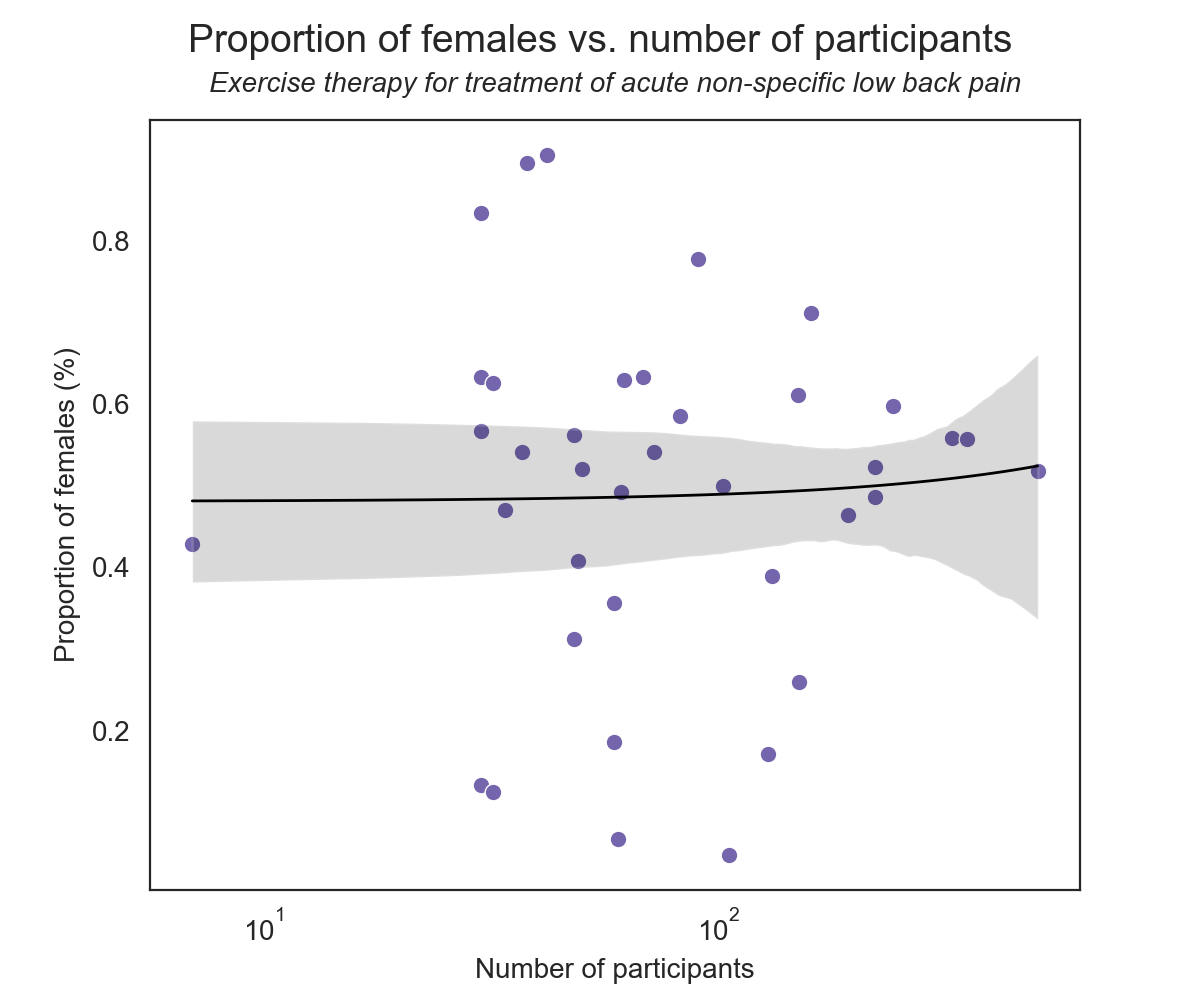

In [955]:
# drop rows with NA in 'total_participants', 'female_pct', or 'nct_id'
sex_data_clean = sex_data.dropna(subset=['total_participants', 'female_pct', 'nct_id'])

# create the scatter plot + add the regression line
plt.figure(figsize=(6, 5))
sns.set_style("white")

# plot
scatter = sns.scatterplot(x='total_participants', y='female_pct', data=sex_data_clean, 
                          color='#7465ad')

sns.regplot(x='total_participants', y='female_pct', data=sex_data_clean, 
            scatter=False, line_kws={"color": "black", "linewidth": 1})

# change to log scale for x-axis
plt.xscale('log')

# add labels for nct_id; 
#for index, row in sex_data_clean.iterrows():
#    plt.text(row['total_participants'], row['female_pct'], 
#             str(row['nct_id']),  # Convert to string to prevent any formatting issues
#             horizontalalignment='left', 
#             size='xx-small',  # Smaller font size
#             color='gray', 
#             weight='semibold',
#             rotation=25)  # Rotate labels by 45 degrees

# plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter())

plt.suptitle('Proportion of females vs. number of participants', x=0.5, y=0.976, fontsize=14)
plt.title('Exercise therapy for treatment of acute non-specific low back pain', fontsize=10, pad=10, fontstyle='italic')

# 'Exercise therapy for treatment of acute non-specific low back pain''
# 'PARP inhibitors for locally advanced or metastatic breast cancer'

# Set axis labels
plt.xlabel('Number of participants')
plt.ylabel('Proportion of females (%)')

plt.show()

## 4.2. Ethnicity data

"Asian", "Black or African American", "Others", "Unknown or Not Reported", "White" will be used

<span style="color:red;">Check the `id_list` variable!</span>

In [956]:
query = f"""
    SELECT nct_id, result_group_id, ctgov_group_code, param_value, classification, category
    FROM baseline_measurements
    WHERE (title = 'Race (NIH/OMB)' OR title = 'Race/Ethnicity, Customized')
    AND nct_id IN ({idlist_1});
"""

extracted_race = pd.read_sql_query(query, engine)

extracted_race.head()
# extracted_race.to_csv('extracted_race.csv', index=False)

,nct_id,result_group_id,ctgov_group_code,param_value,classification,category
0,NCT03888235,76585916,BG000,0,None,American Indian or Alaska Native
1,NCT03888235,76585917,BG001,0,None,American Indian or Alaska Native
2,NCT03888235,76585918,BG002,0,None,American Indian or Alaska Native
3,NCT03888235,76585919,BG003,0,None,American Indian or Alaska Native
4,NCT03888235,76585916,BG000,0,None,Asian


We will now create a heatmap on the captured ethnicity data

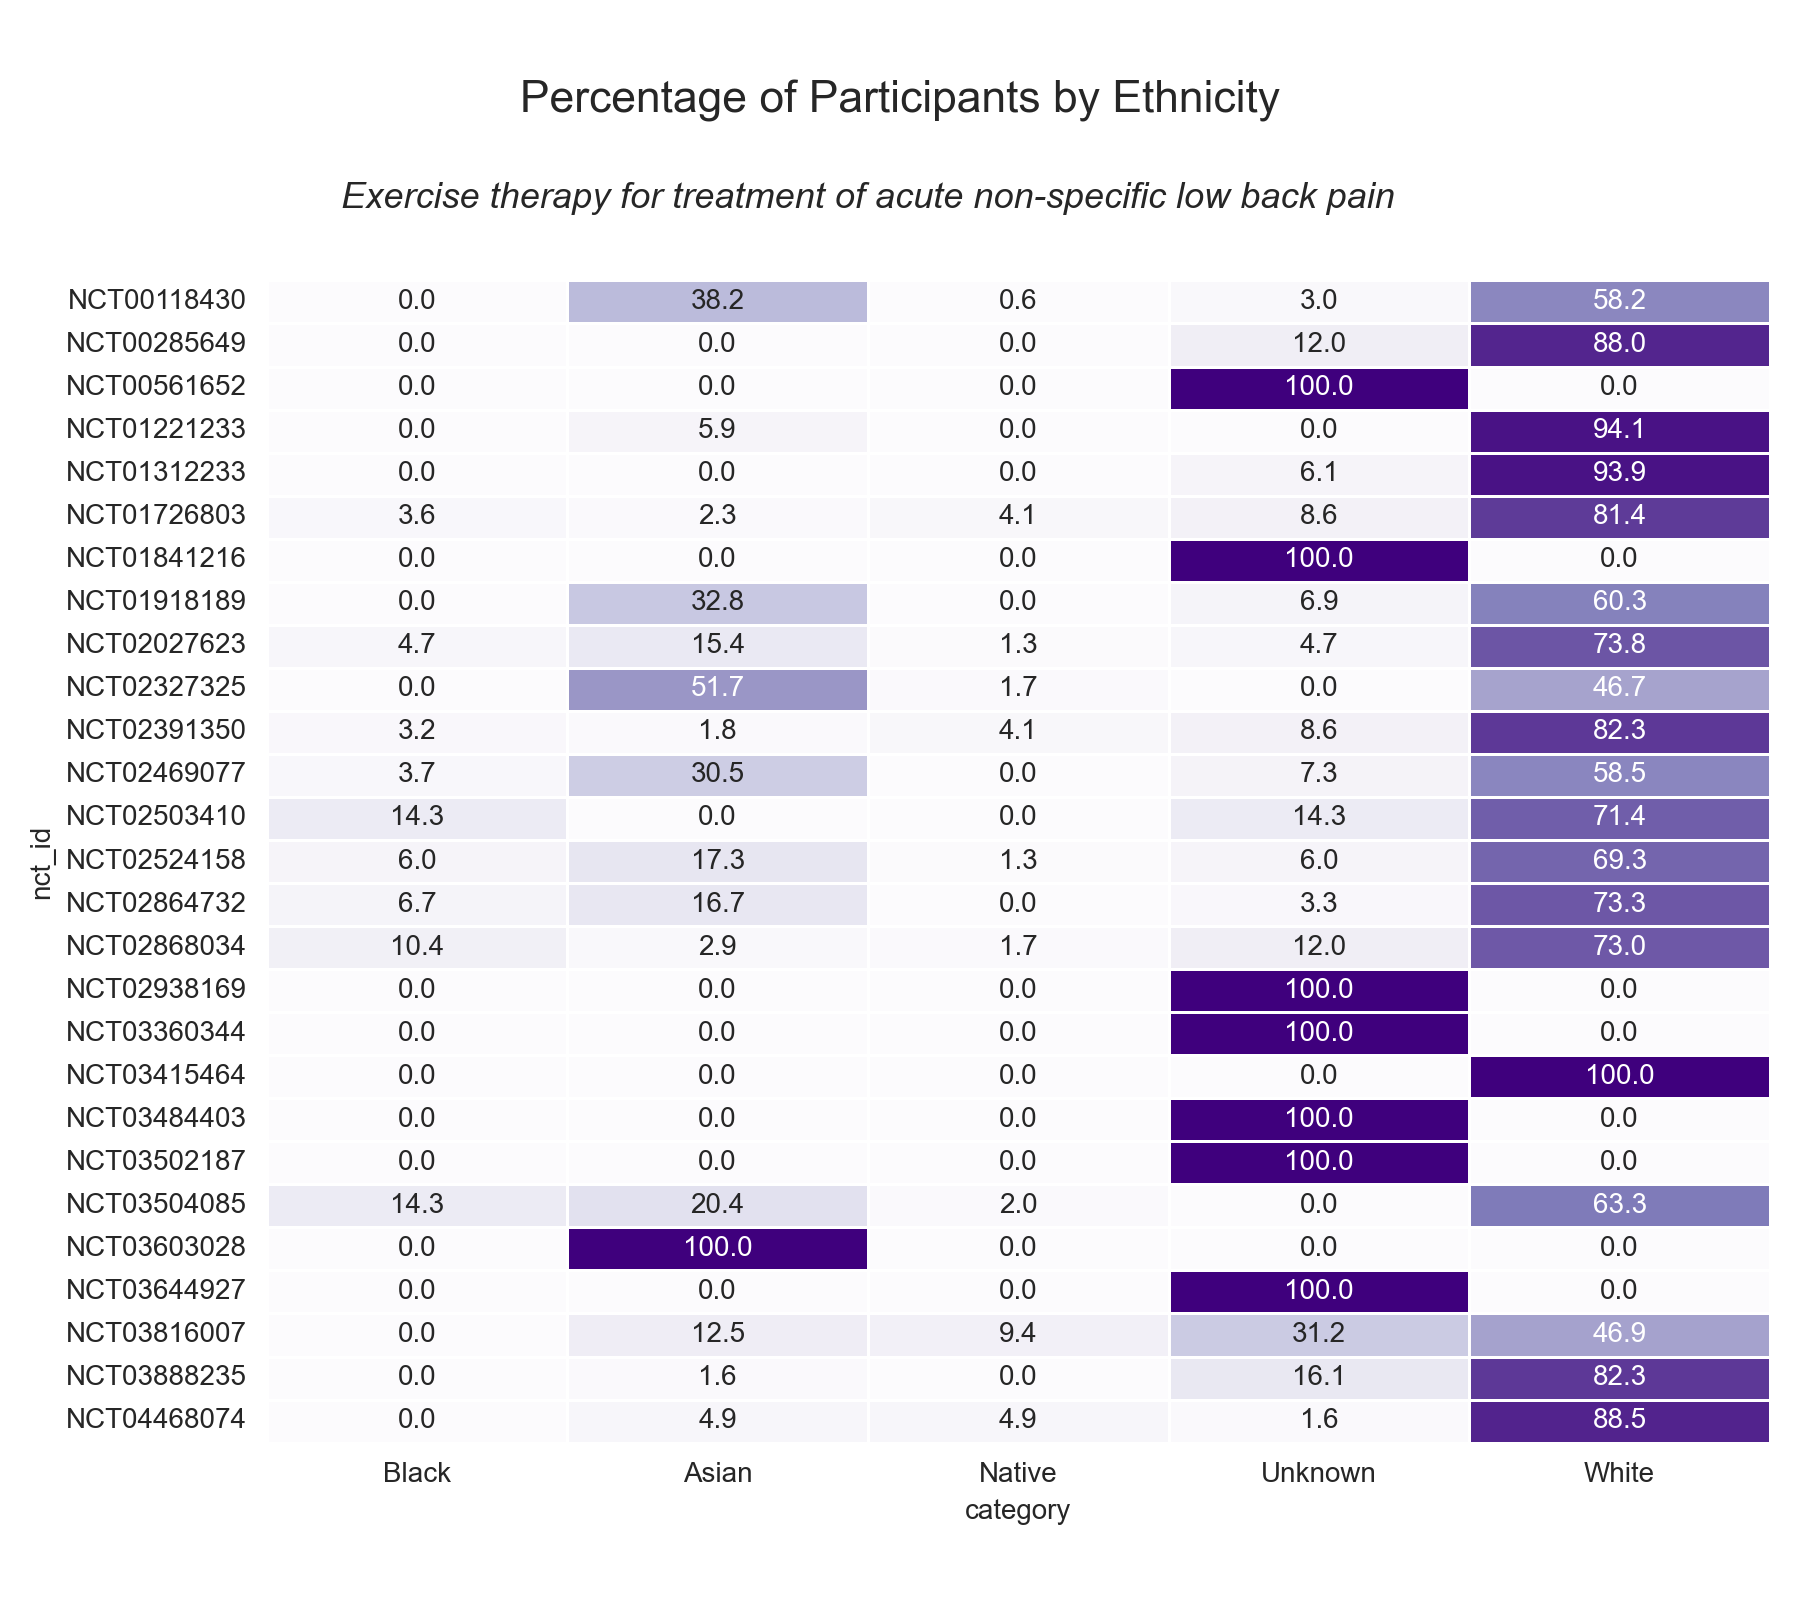

In [957]:
# define the desired category_mapping
category_mapping = {
    'Black': 'Black or African American',
    'BLACK OR AFRICAN AMERICAN': 'Black or African American',
    'Black Or African American': 'Black or African American',
    'ASIAN': 'Asian',
    'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER': 'Native',
    'Native Hawaiian or Pacific Islander': 'Native',
    'White or Caucasian': 'White',
    'AMERICAN INDIAN OR ALASKA NATIVE': 'Native',
    'American Indian Or Alaska Native': 'Native',
    'WHITE': 'White',
    'Unknown': 'Unknown or Not Reported',
    'Missing': 'Unknown or Not Reported',
    'Other': 'Unknown or Not Reported',
    'OTHER': 'Unknown or Not Reported',
    'MISSING': 'Unknown or Not Reported',
    'No ethnicity': 'Unknown or Not Reported',
    'Other, not specified': 'Unknown or Not Reported',
    'Multiple': 'Unknown or Not Reported'
}


extracted_race['category'] = extracted_race['category'].astype(str).str.upper().str.strip()

# ensure consistency -uppercase
category_mapping_updated = {k.upper(): v for k, v in category_mapping.items()}

# apply cat mapping
extracted_race_filtered = extracted_race.copy()
extracted_race_filtered['category'] = extracted_race_filtered['category'].map(category_mapping_updated).fillna('Unknown or Not Reported')

extracted_race_filtered['param_value'] = pd.to_numeric(extracted_race_filtered['param_value'], errors='coerce')

pivoted_race = extracted_race_filtered.pivot_table(index='nct_id', columns='category', values='param_value', aggfunc='sum', fill_value=0)

pivoted_race_percentage = pivoted_race.div(pivoted_race.sum(axis=1), axis=0) * 100

# heatmap
plt.figure(figsize=(9, 8))  
ax = sns.heatmap(pivoted_race_percentage, annot=True, linewidths=.5, cmap='Purples', cbar=False, fmt=".1f")

plt.suptitle('Percentage of Participants by Ethnicity', x=0.5, y=0.95, fontsize=16)
plt.title('Exercise therapy for treatment of acute non-specific low back pain', 
          x=0.4, y=1, fontsize=13, pad=26, 
          fontdict={'fontstyle': 'italic'})

# 'Exercise therapy for treatment of acute non-specific low back pain'
# 'PARP inhibitors for locally advanced or metastatic breast cancer'


custom_labels = ["Black", "Asian", "Native", "Unknown", "White"]

ax.set_xticklabels(custom_labels)

plt.yticks(fontsize=10, rotation=0)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

In [958]:
extracted_race_filtered.to_csv('3.bsssssssss.csv', index=False)

## 4.3 Next, we'll focus on age

In [959]:
age_data = baseline_data.loc[baseline_data['title'] == 'Age, Continuous']

In [960]:
age_data;

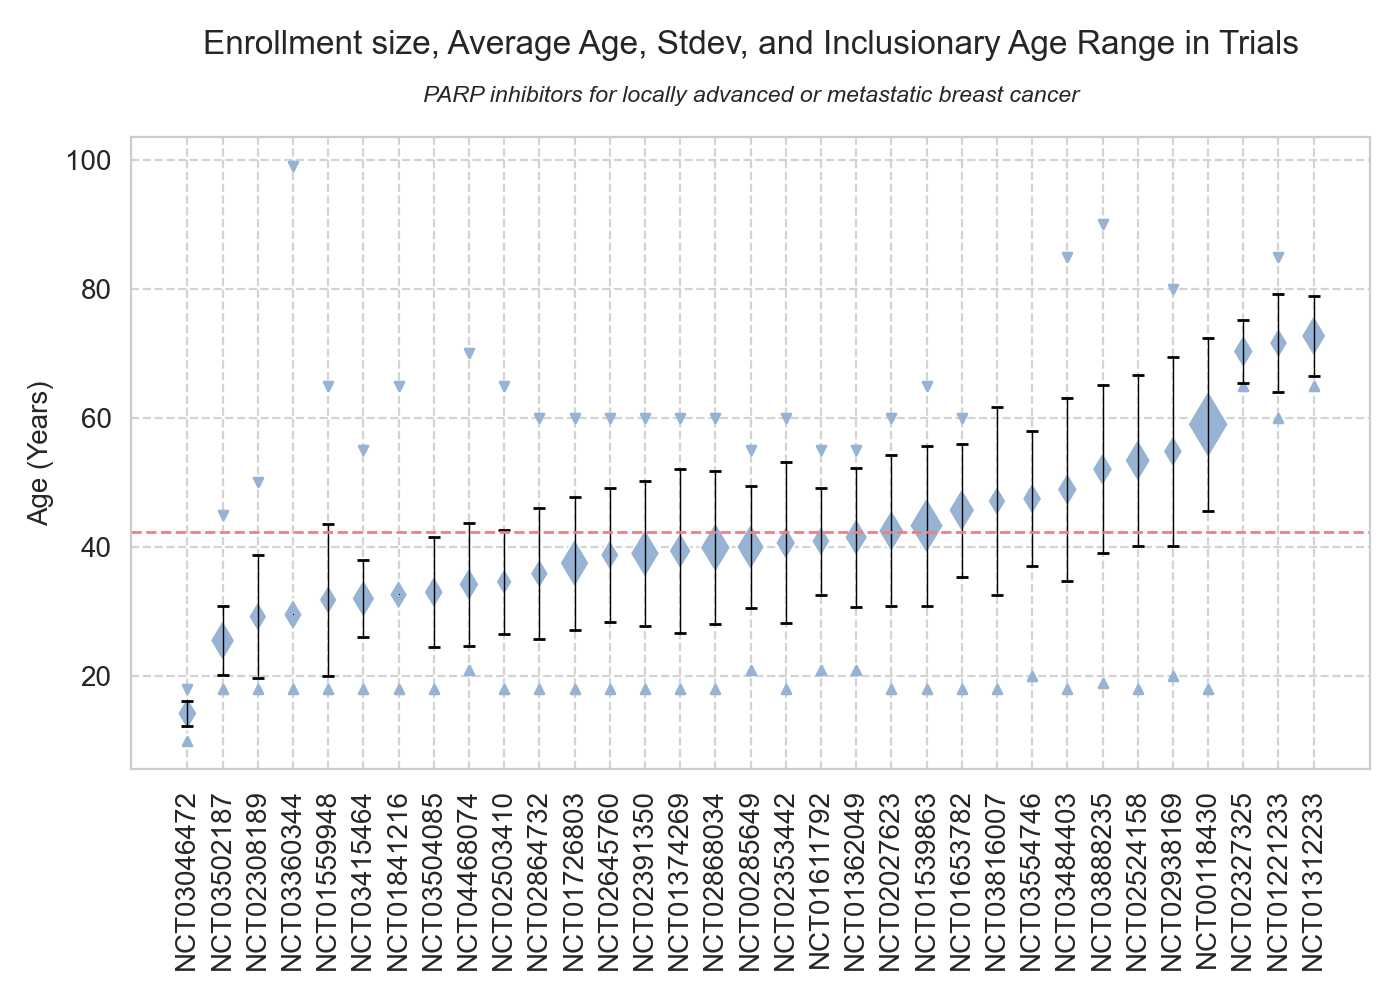

In [961]:
age_data_copy = age_data.copy()

# data preprocessing
age_data_copy['minimum_age'] = age_data_copy['minimum_age'].str.extract('(\d+)').astype(float)
age_data_copy['maximum_age'] = age_data_copy['maximum_age'].replace('N/A', pd.NA)
age_data_copy['maximum_age'] = age_data_copy['maximum_age'].str.extract('(\d+)').astype(float)
age_data_copy['Average Age'] = age_data_copy['param_value_num']
age_data_copy['Standard Dev'] = age_data_copy['dispersion_value_num']

# calc overall average age
overall_average_age = age_data_copy['Average Age'].mean()

# sort on 'Average Age' -- reset the index
age_data_copy = age_data_copy.sort_values(by='Average Age').reset_index(drop=True)

#plotting
plt.figure(figsize=(7, 5))
sns.set_style("whitegrid", {'axes.grid': True, 'grid.linestyle': '--', 'grid.color': 'lightgrey'})

sns.scatterplot(data=age_data_copy, x=range(len(age_data_copy)), y='Average Age', size='number_analyzed', sizes=(50, 300), legend=False, color='#96B3D3', marker='d')
plt.errorbar(range(len(age_data_copy)), age_data_copy['Average Age'], yerr=age_data_copy['Standard Dev'], fmt=',', color='black', elinewidth=.5, capsize=2.0)

# add red markers for age range -- plot minimum and maximum age
for index, row in age_data_copy.iterrows():
    plt.scatter([index], [row['minimum_age']], color='#96B3D3', marker='^', s=10)
    if pd.notna(row['maximum_age']):
        plt.scatter([index], [row['maximum_age']], color='#96B3D3', marker='v', s=10)

# adding the overall average age line to run across the plot
plt.axhline(y=overall_average_age, color='lightcoral', linestyle='--', linewidth=1)

n = 1  # adjust n as needed to reduce clutter -- plots only certain interval on nct_id's
plt.xticks(range(len(age_data_copy))[::n], age_data_copy['nct_id'][::n], rotation=90, fontsize=10)

plt.ylabel('Age (Years)')
plt.title('Enrollment size, Average Age, Stdev, and Inclusionary Age Range in Trials', pad=30)
plt.text(0.5, 1.05, 'PARP inhibitors for locally advanced or metastatic breast cancer', 
         ha='center', va='bottom', transform=plt.gca().transAxes, 
         fontsize='smaller', fontstyle='italic')
# 'Exercise therapy for treatment of acute non-specific low back pain'
# 'PARP inhibitors for locally advanced or metastatic breast cancer'

# before show, save it
#plt.savefig('age_analysis_plot.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

* Blue diamonds (location) represent the average age for each trial (nct_id). The size of each diamond corresponds to the total_count of participants in that trial.

* Black Error Bars: Indicate the standard deviation of age for each trial.

* Tiny blue arrows represent the age range of inclusion criteria (minimum to maximum age) for each trial if recorded (some trials might have only one/neither recorded)

* Red line marks the average across across trials.

### 4.4. Combine clinical variables for later k-means clustering

In [963]:
# Finally, let us also combine all the clinical variables into one dataframe for later analysis

# Step 1: Merge trial_data and sex_data
merged_data = pd.merge(trial_data[['nct_id', 'enrollment']], sex_data[['nct_id', 'female_pct']], on='nct_id', how='inner')

# Step 2: Merge with pivoted_race
pivoted_race_percentage = pivoted_race_percentage.reset_index()

merged_data2 = pd.merge(merged_data, pivoted_race_percentage[['nct_id', 'White']], on='nct_id', how='inner')

clinical_data = pd.merge(merged_data2, age_data[['nct_id', 'param_value_num']], on='nct_id', how='inner')

clinical_data['White'] = clinical_data['White']  / 100

clinical_data = clinical_data.rename(columns={
    'White': 'white_pct',
    'param_value_num': 'avg_age',
    'minimum_age': 'min_age',
    'maximum_age': 'max_age',
})

clinical_data.head

# clinical_data = clinical_data.drop_duplicates()
# clinical_data = clinical_data.dropna()

<bound method NDFrame.head of          nct_id  enrollment  female_pct  white_pct  avg_age
0   NCT00118430         500    0.518000   0.582000    59.00
1   NCT00285649         192    0.463542   0.880208    40.00
2   NCT01221233          38    0.470588   0.941176    71.60
3   NCT01312233         131    0.389313   0.938931    72.70
4   NCT01726803         220    0.522727   0.813636    37.50
5   NCT01841216          30    0.566667   0.000000    32.60
6   NCT02027623         154    0.610738   0.738255    42.50
7   NCT02327325          60    0.066667   0.466667    70.30
8   NCT02391350         220    0.486364   0.822727    39.00
9   NCT02503410           7    0.428571   0.714286    34.60
10  NCT02524158         152    0.260000   0.693333    53.40
11  NCT02864732          30    0.633333   0.733333    35.87
12  NCT02868034         273    0.597510   0.730290    39.90
13  NCT02938169          60    0.312500   0.000000    54.81
14  NCT03360344          44    0.904762   0.000000    29.50
15  NCT034

# 5. Study-level data (methdological heterogeneity)

* `studies` (s) table: official_title, enrollment, number_of_arms, phase, and overall_status.

* `designs` (d): allocation, intervention_model, and masking

* `calculated_values` (cv): actual_duration and number_of_facilities

* `sponsors` (sp): information about the sponsors of each study

<span style="color:red;">Check the `id_list` variable!</span>

In [964]:
query = f"""
SELECT
    s.nct_id,
    s.official_title,
    d.intervention_model,
    d.masking,
    s.enrollment,
    s.number_of_arms,
    s.phase,
    s.overall_status,
    cv.actual_duration,
    cv.number_of_facilities,
    STRING_AGG(sp.name, ', ') AS sponsor_names
FROM
    {schema}.studies s
LEFT JOIN {schema}.designs d ON s.nct_id = d.nct_id
LEFT JOIN {schema}.calculated_values cv ON s.nct_id = cv.nct_id
LEFT JOIN {schema}.sponsors sp ON s.nct_id = sp.nct_id
WHERE
    s.nct_id IN ({idlist_1})
GROUP BY s.nct_id, s.official_title, d.allocation, d.intervention_model, d.masking, s.enrollment, s.number_of_arms, s.phase, s.overall_status, cv.actual_duration, cv.number_of_facilities
"""

methodological_data = pd.read_sql_query(query, engine)

In [966]:
methodological_data.head()
# methodological_data.to_csv('methodological_data.csv', index=False)

,nct_id,official_title,intervention_model,masking,enrollment,number_of_arms,phase,overall_status,actual_duration,number_of_facilities,sponsor_names
0,NCT00118430,Stepped Care for Affective Disorders and Muscu...,Parallel Assignment,None (Open Label),500,3,Phase 4,Completed,46,1.0,"Indiana University, National Institute of Ment..."
1,NCT00285649,Predicting Patients' Response to Spinal Manipu...,Parallel Assignment,Single,192,3,Not Applicable,Completed,27,1.0,"Palmer College of Chiropractic, Department of ..."
2,NCT00561652,Education/Exercise and Chiropractic for Chroni...,Parallel Assignment,None (Open Label),30,2,Not Applicable,Completed,15,1.0,"US Department of Veterans Affairs, Northwester..."
3,NCT00786864,School-Based Specific Exercise Programme Reduc...,Parallel Assignment,Double,72,2,Not Applicable,Completed,9,1.0,"University of Witwatersrand, South Africa"
4,NCT00803413,Effect of Back School and Supervised Walking i...,Parallel Assignment,Double,119,4,Not Applicable,Completed,10,1.0,University of Sao Paulo


## 5.1. Main methodological characteristics: exploratory scatter plot

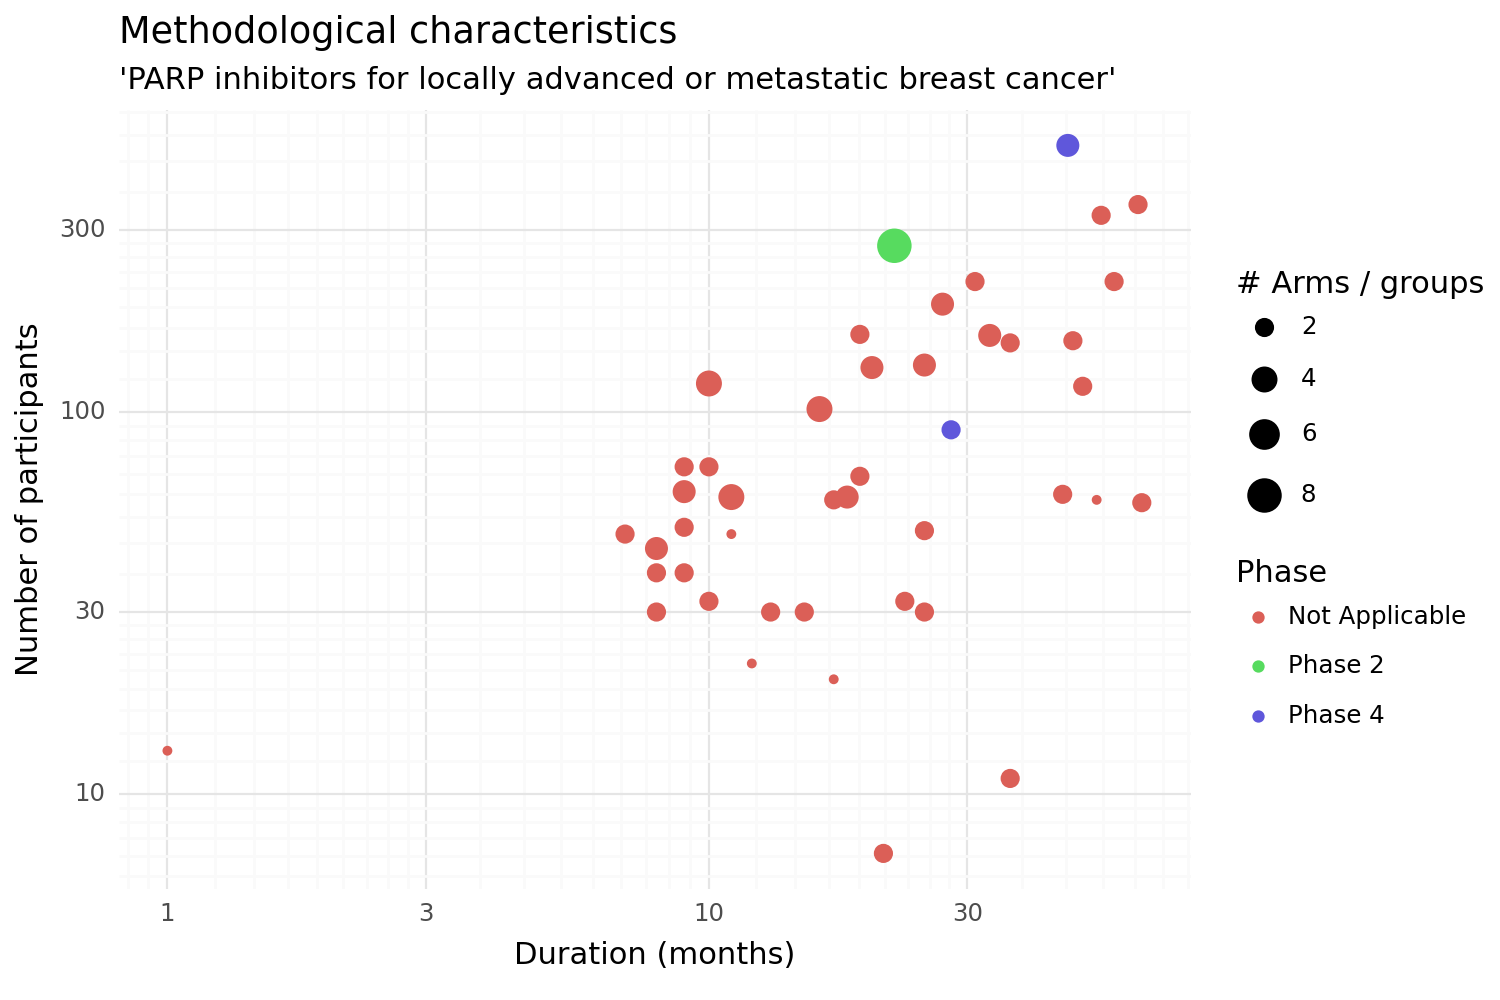

In [967]:
methodological_data['phase'] = pd.Categorical(methodological_data['phase'])

plot = (ggplot(methodological_data, aes(x='actual_duration', y='enrollment', size='number_of_arms', color='phase'))
        + labs(title="Methodological characteristics",
               subtitle = "'PARP inhibitors for locally advanced or metastatic breast cancer'",
               x="Duration (months)",
               y="Number of participants",
               color="Phase",
               size="# Arms / groups")
        + geom_point()
        + scale_x_log10()
        + scale_y_log10()
        + theme_minimal()
        + theme(figure_size=(7.5, 5))  # Adjust as needed
       )

print(plot)

# 'Exercise therapy for treatment of acute non-specific low back pain'
# 'PARP inhibitors for locally advanced or metastatic breast cancer'

#plot.save(filename="methodological_characteristics.svg", height=5, width=7.5, units='in', dpi=300)

### 5.1.1. Interactive version of the same plot for a quick NCT_ID retrieval / exploration

In [968]:
# disclaimer: not as nice lookign as above but is meant to complement the above plot
methodological_data['phase'] = methodological_data['phase'].astype(str)

# create the interactive plot -- we are using plotly lib
fig = px.scatter(methodological_data, x='actual_duration', y='enrollment',
                 size='number_of_arms', color='phase', hover_data=['nct_id'],
                 log_x=True, log_y=True,
                 title="Methodological characteristics--accessory plot",
                 labels={
                     "actual_duration": "Duration (months)",
                     "enrollment": "Number of participants",
                     "phase": "Phase",
                     "number_of_arms": "# Arms / groups"
                 })

# 'Exercise therapy for treatment of acute non-specific low back pain'
# 'PARP inhibitors for locally advanced or metastatic breast cancer'

fig.update_layout(autosize=False, width=750, height=500)
fig.show()

### 5.2. Combine methodological data for later k-means clustering

In [969]:
# finally, let us also combine all the relevant methodolocial variables into one dataframe for later analysis

# first, we must select desired methodological variables
columns_to_merge = [
    'nct_id', 
    'intervention_model', 
    'masking', 
    'enrollment', 
    'number_of_arms', 
    'phase', 
    'actual_duration', 
    'number_of_facilities',
]

method_data = methodological_data[columns_to_merge]
method_data = method_data.drop_duplicates()
method_data = method_data.dropna()


#data = data.drop_duplicates()
#data = data.dropna()

### 5.3. Combine all the variables into one neat dataframe

In [970]:
# merging both clinical_data + method_data into one df
# define columns we want to keep from 'clinical_data'
columns_to_merge = ['nct_id', 'female_pct', 'white_pct', 'avg_age']

# merge selected columns from clinical_data with all columns from method_data
data = pd.merge(clinical_data[columns_to_merge], method_data, on='nct_id', how='inner')
data.head()

#data = data.drop_duplicates()
#data = data.dropna()

# for a maximally compact-nice looking table for efficient presentation (optional):

data.rename(columns={'number_of_arms': 'arms', 'actual_duration': 'duration'}, inplace=True)
# data['phase'] = data['phase'].str.replace('Phase ', '')  # Remove the word 'Phase'
# data['phase'] = data['phase'].replace('Not Applicable', 'NA')  # Replace 'Not Applicable' with 'NA'
# data['masking'] = data['masking'].replace('None (Open Label)', 'None')
# data['intervention_model'] = data['intervention_model'].str.replace(' Assignment', '')
# data['female_pct'] = (data['female_pct'] * 100).round()
# data['white_pct'] = (data['white_pct'] * 100).round()
# data.rename(columns={'intervention_model': 'interv_type'}, inplace=True)
# data.rename(columns={'enrollment': 'enrol'}, inplace=True)
# print(data.to_string()) # a plain format type

# data.to_csv('data.csv', index=False)

# <span style="color:blue">6. Finding outliers using K-means</span>

* We are using KMeans to find outliers in a cluster of clinical trials.
* Option 1: Finding outliers means finding the centroid(s) and then highlighting the furthers trials by their (Euclidean) distance from the centroid(s).
* Option 2: Assigning trials to chosen number of clusters; smallest clusters reveal outliers.

### <span style="color:blue">We are doing three sets of K-means clusterings: clinical, methodological and combined.</span>

For clinical variables, we use `clinical_data` that has the following variables: `enrollement`, `female_pct`, `white_pct`, `avg_age`. We cluster on these to group trials by similar population characteristics.

In [971]:
num_cols = ['enrollment', 'female_pct', 'white_pct', 'avg_age']

For methodological variables, we use `method_data` with the following variables: `intervention_model`, `masking`, `enrollment`, `number_of_arms`, `phase`, `actual_duration`, `number_of_facilities`. We cluster on these to group by trial design factors.

In [972]:
num_cols = ['enrollment', 'number_of_arms', 'actual_duration', 'number_of_facilities']
cat_cols = ['intervention_model', 'masking', 'phase']

For the combined clustering, we will use the above defined `data` with all the above variables

## <span style="color:blue">6.1. Clinical heterogeneity: Find the optimal number of clusters.</span>

In [973]:
clinical_data.head()

,nct_id,enrollment,female_pct,white_pct,avg_age
0,NCT00118430,500,0.518000,0.582000,59.0
1,NCT00285649,192,0.463542,0.880208,40.0
2,NCT01221233,38,0.470588,0.941176,71.6
3,NCT01312233,131,0.389313,0.938931,72.7
4,NCT01726803,220,0.522727,0.813636,37.5


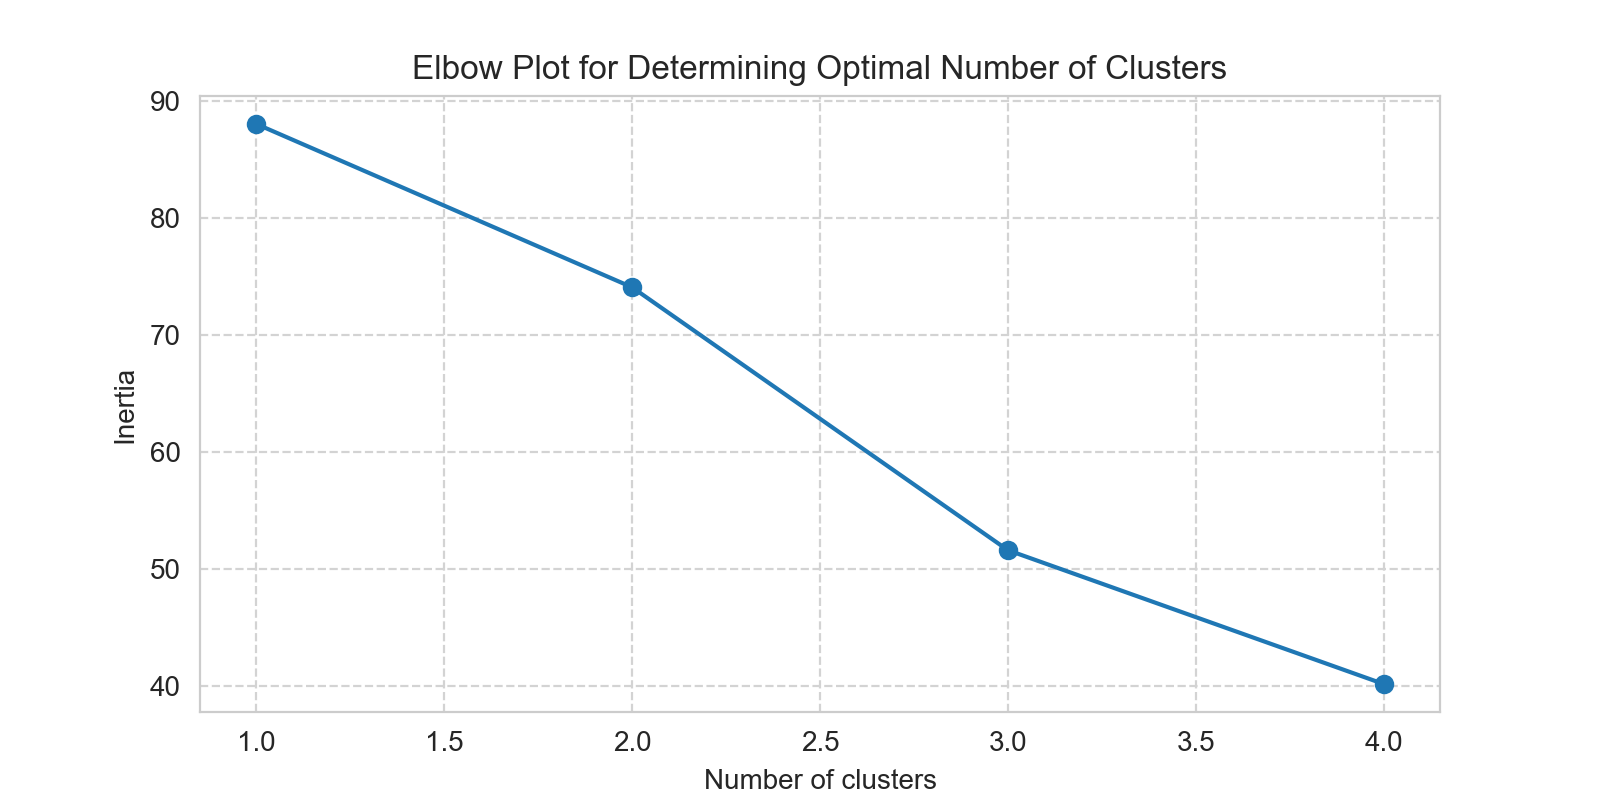

In [974]:
# numerical columns
num_cols = ['enrollment', 'female_pct', 'white_pct', 'avg_age']

# standardize them
scaler = StandardScaler()
X_preprocessed = scaler.fit_transform(clinical_data[num_cols])

# determine the optimal number of clusters using the Elbow method
inertia = []
K = range(1, 5) # adjust; needs <11 when we have less data
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=1)
    kmeanModel.fit(X_preprocessed)
    inertia.append(kmeanModel.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K, inertia, 'o-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Plot for Determining Optimal Number of Clusters')
plt.show()

Based on the elbow plot, we would select the number of clusters where the inertia starts to decrease at a slower rate.

##  <span style="color:blue">6.2. Clinical heterogeneity: K-Means Clustering</span>

<span style="color:red;">change the kmeans = KMeans(n_clusters=1) AND n_clusters variable</span>

In [975]:
clinical_data

,nct_id,enrollment,female_pct,white_pct,avg_age
0,NCT00118430,500,0.518000,0.582000,59.00
1,NCT00285649,192,0.463542,0.880208,40.00
2,NCT01221233,38,0.470588,0.941176,71.60
3,NCT01312233,131,0.389313,0.938931,72.70
4,NCT01726803,220,0.522727,0.813636,37.50
5,NCT01841216,30,0.566667,0.000000,32.60
6,NCT02027623,154,0.610738,0.738255,42.50
7,NCT02327325,60,0.066667,0.466667,70.30
8,NCT02391350,220,0.486364,0.822727,39.00
9,NCT02503410,7,0.428571,0.714286,34.60


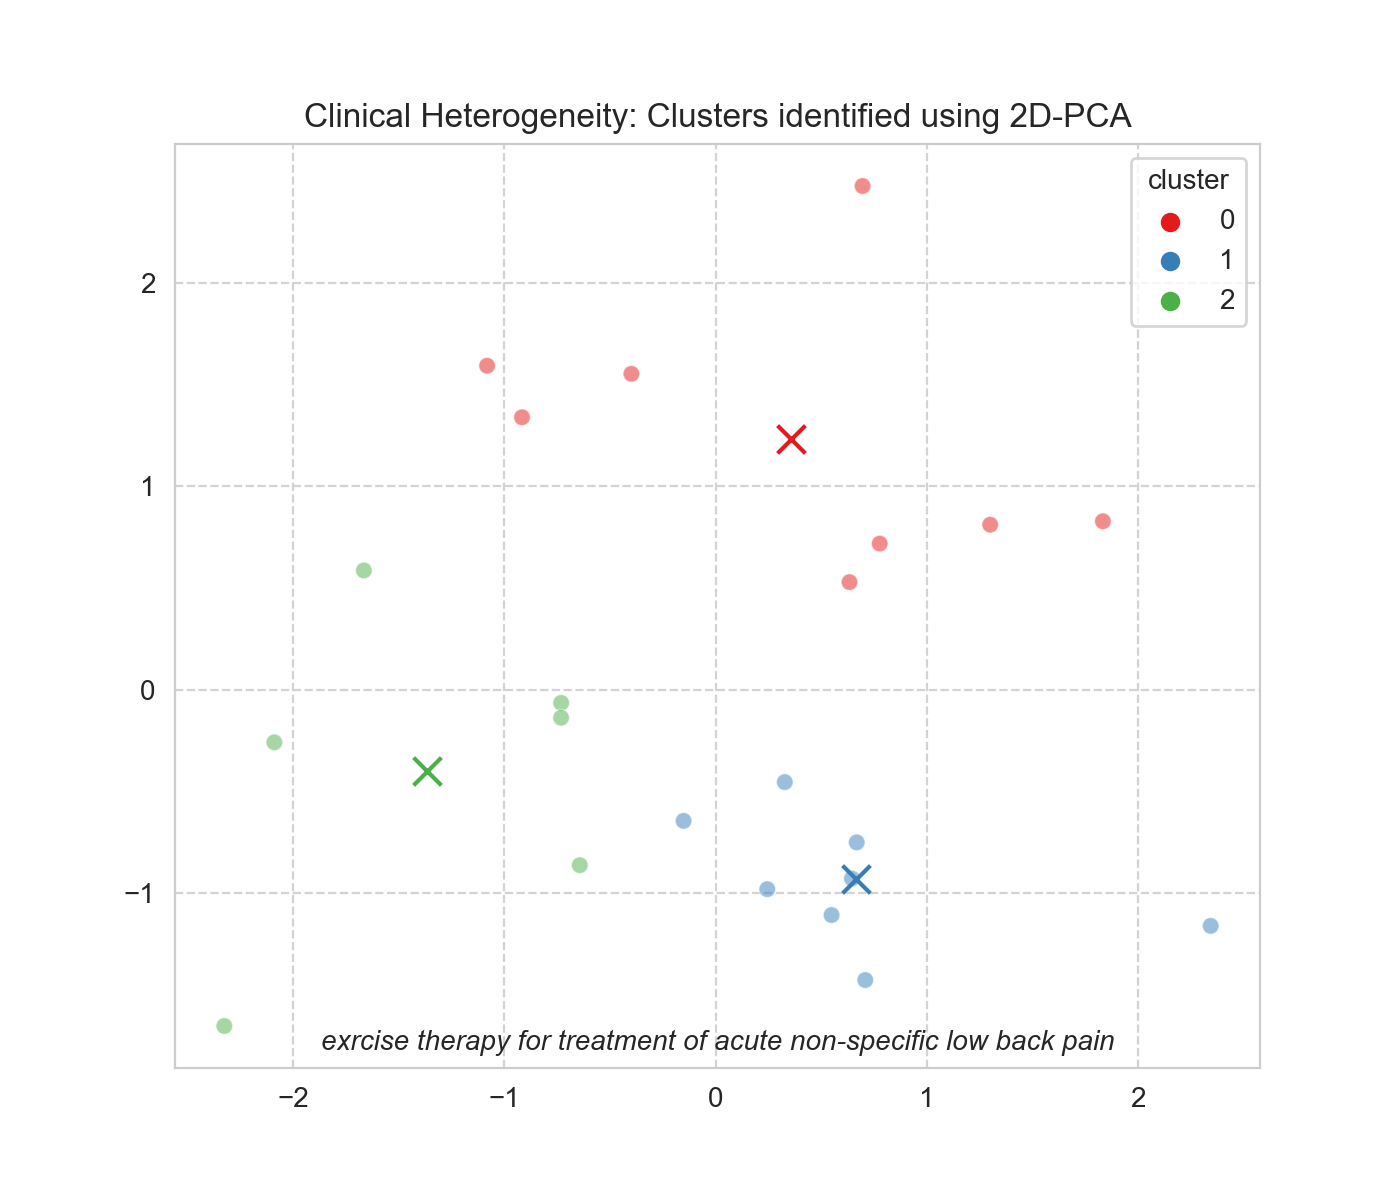

In [976]:
# numerical features
scaler = StandardScaler()
X_preprocessed = scaler.fit_transform(clinical_data[num_cols])

# PCA to reduce to 2 components
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_preprocessed)

# K-Means clustering on PCA components
kmeans = KMeans(n_clusters=3)  # adjust
clinical_data['cluster'] = kmeans.fit_predict(pca_components)

# calc cluster centroids
centroids = kmeans.cluster_centers_

n_clusters = 3  # change
cluster_colors = sns.color_palette('Set1', n_colors=n_clusters)

# scatter plot
plt.figure(figsize=(7, 6))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=clinical_data['cluster'], palette=cluster_colors, alpha=0.5, legend=True)

# highlight cluster centroids
for i, centroid in enumerate(centroids):
    plt.scatter(centroid[0], centroid[1], marker="x", color=cluster_colors[i], s=100, label=f'Centroid {i}')

plt.title('Clinical Heterogeneity: Clusters identified using 2D-PCA')
plt.text(0.5, 0.02, 'exrcise therapy for treatment of acute non-specific low back pain', transform=plt.gca().transAxes, 
         ha='center', fontsize=10, style='italic')

# 'Exercise therapy for treatment of acute non-specific low back pain'
# 'PARP inhibitors for locally advanced or metastatic breast cancer'

plt.show()

## <span style="color:blue">6.3. Next, we can examine these trial(s) to understand what makes them stand out. Are they exceptionally large or small in enrollment, do they have an unusually high or low number of arms, or are their durations significantly different from the norm?</span>

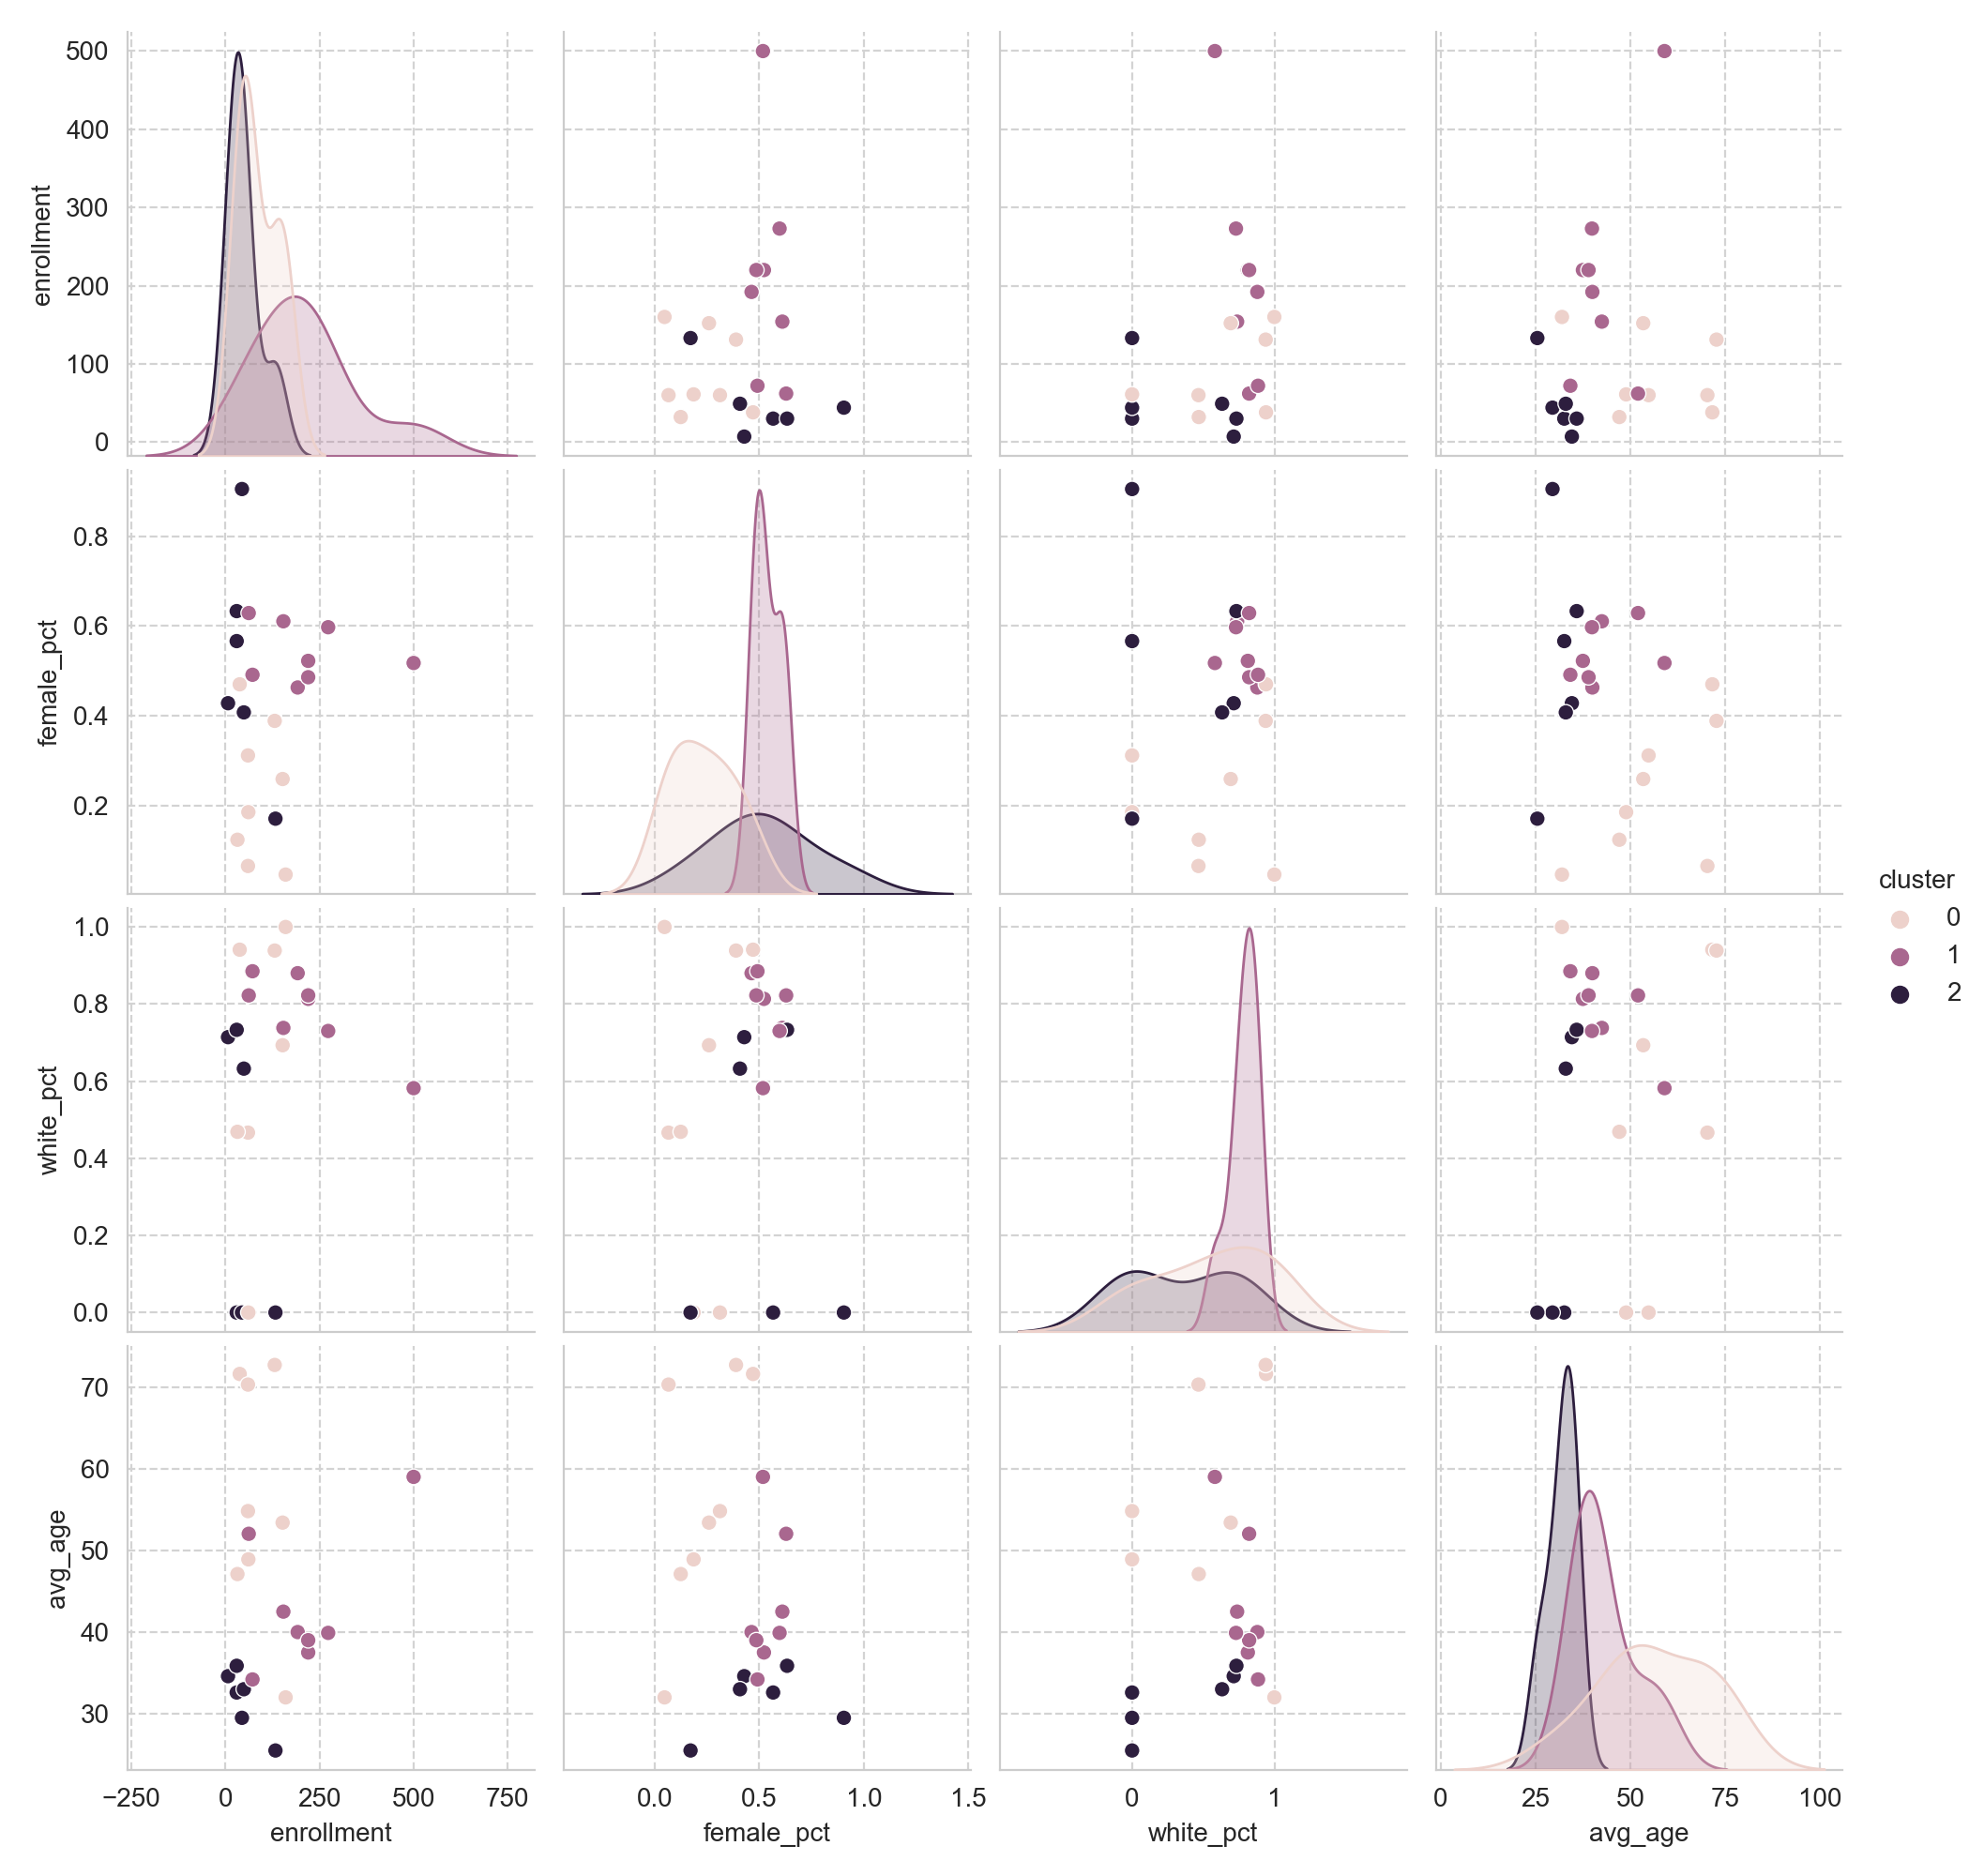

In [977]:
# create a pairwise comparison across clinical variables
sns.pairplot(clinical_data, hue="cluster")
plt.show()

## <span style="color:blue">7.1. Methodolocial heterogeneity: Find the optimal number of clusters</span>

In [980]:
method_data.head()
#method_data = method_data.dropna()

,nct_id,intervention_model,masking,enrollment,number_of_arms,phase,actual_duration,number_of_facilities
0,NCT00118430,Parallel Assignment,None (Open Label),500,3,Phase 4,46,1.0
1,NCT00285649,Parallel Assignment,Single,192,3,Not Applicable,27,1.0
2,NCT00561652,Parallel Assignment,None (Open Label),30,2,Not Applicable,15,1.0
3,NCT00786864,Parallel Assignment,Double,72,2,Not Applicable,9,1.0
4,NCT00803413,Parallel Assignment,Double,119,4,Not Applicable,10,1.0


<function matplotlib.pyplot.show(close=None, block=None)>

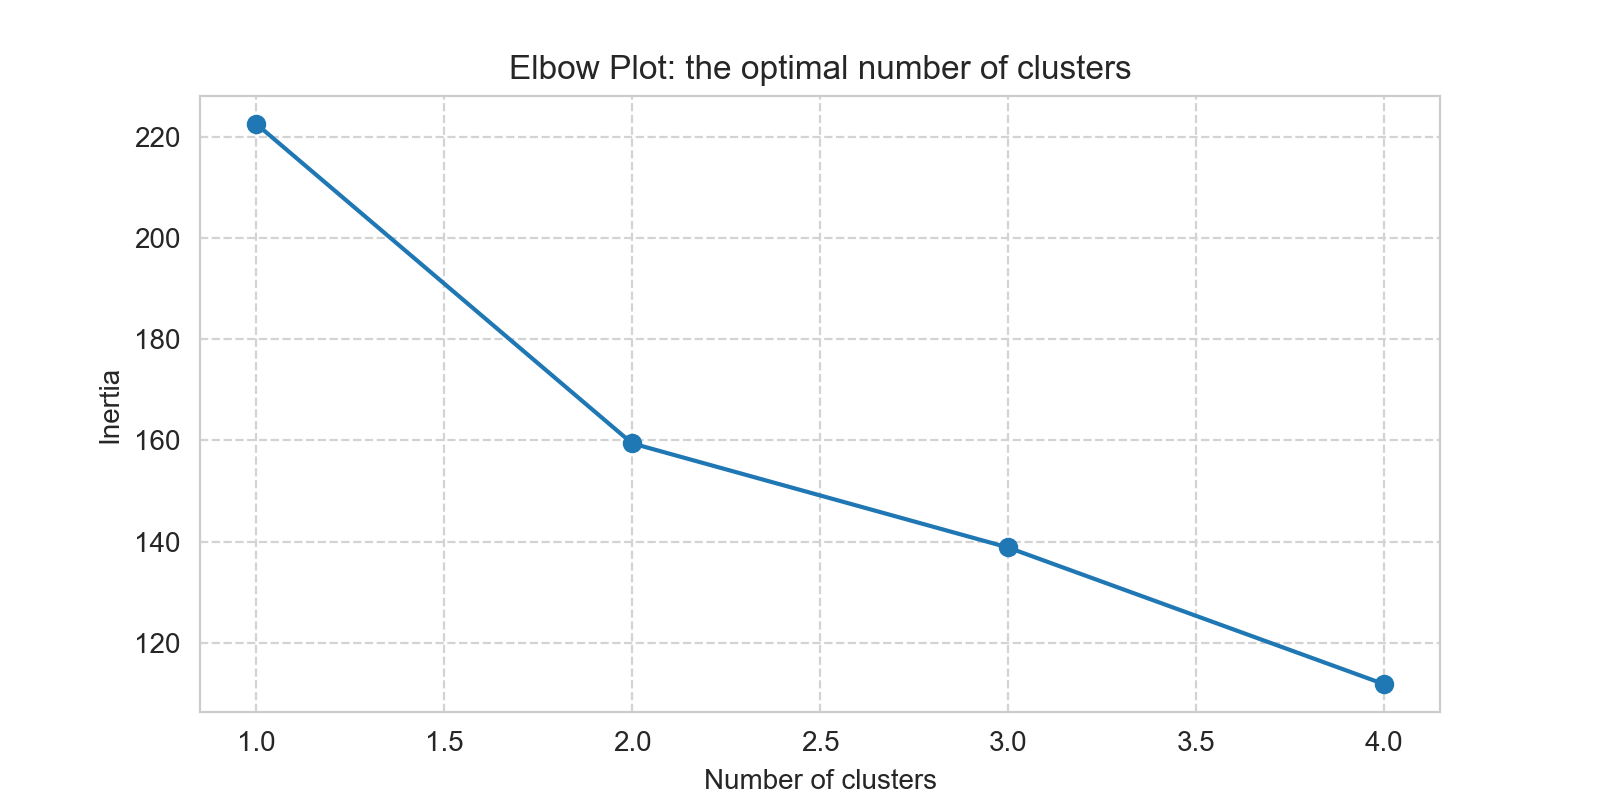

In [981]:
# select desired variables
num_cols = ['enrollment', 'number_of_arms', 'actual_duration', 'number_of_facilities']
cat_cols = ['intervention_model', 'masking', 'phase']

# next, we create a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(), cat_cols)
    ])

X = method_data # select the dataframe

# apply preprocessing to our above data
X_preprocessed = preprocessor.fit_transform(X)

# determine the optimal number of clusters using the Elbow method: ranging from 1 to x clusters
inertia = []
K = range(1,5)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=1)
    kmeanModel.fit(X_preprocessed)
    inertia.append(kmeanModel.inertia_)

# plot 'elbow' figure
plt.figure(figsize=(8, 4))
plt.plot(K, inertia, 'o-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Plot: the optimal number of clusters')
plt.show

##  <span style="color:blue">7.2. Methodological heterogeneity: K-Means Clustering</span>

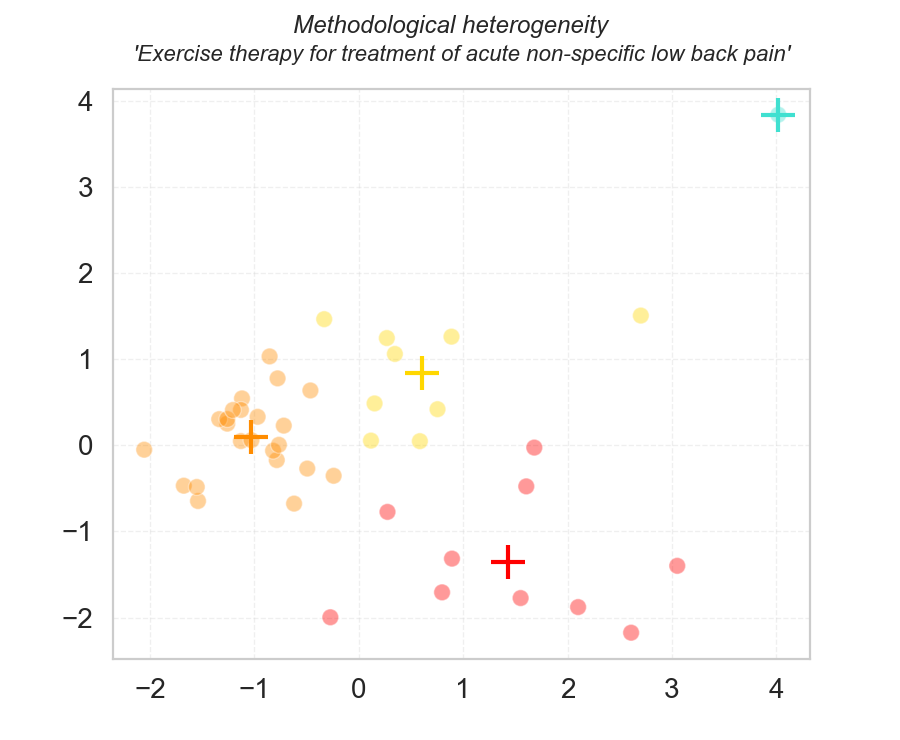

In [982]:
# Define columnsl we use 'method_data'
num_cols = ['enrollment', 'number_of_arms', 'actual_duration', 'number_of_facilities']
cat_cols = ['intervention_model', 'masking', 'phase']


# create the column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(), cat_cols)
    ])

# applying preprocessing
X_preprocessed = preprocessor.fit_transform(method_data)

# applying PCA to reduce to 2 components
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_preprocessed)

# perform K-Means clustering on the PCA components
n_clusters = 4  # adjust!
kmeans = KMeans(n_clusters=n_clusters, random_state=1)
clusters = kmeans.fit_predict(pca_components)
# assign cluster labels back to 'method_data'
method_data.loc[:, 'cluster'] = clusters

# custom colors for each cluster
custom_colors = ["red", "darkorange", "gold", "turquoise", "darkgreen"]

# create a scatter plot
plt.figure(figsize=(4.5, 3.7))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=method_data['cluster'], palette=custom_colors, alpha=0.4, legend=False)

# plot cluster centroids
for i, centroid in enumerate(kmeans.cluster_centers_):
    plt.scatter(centroid[0], centroid[1], marker="+", color=custom_colors[i], s=150, alpha=1, label=f'Centroid {i}')

plt.suptitle("Methodological heterogeneity", fontstyle='italic', fontsize=8.7, x=0.5, ha='center')
plt.title("'Exercise therapy for treatment of acute non-specific low back pain'", fontsize=8, style='italic', pad=10)

# 'Exercise therapy for treatment of acute non-specific low back pain'
# 'PARP inhibitors for locally advanced or metastatic breast cancer'

# Set legend in the best location
#plt.legend(loc='best')

# Set grid with specified properties
plt.grid(True, which='both', axis='both', color='lightgray', alpha=0.35, linestyle='--', linewidth=0.5)

# Show the plot
plt.show()

## <span style="color:blue">7.3. Next, we can examine these trial(s) to understand what makes them stand out. Are they exceptionally large or small in enrollment, do they have an unusually high or low number of arms, or are their durations significantly different from the norm?</span>

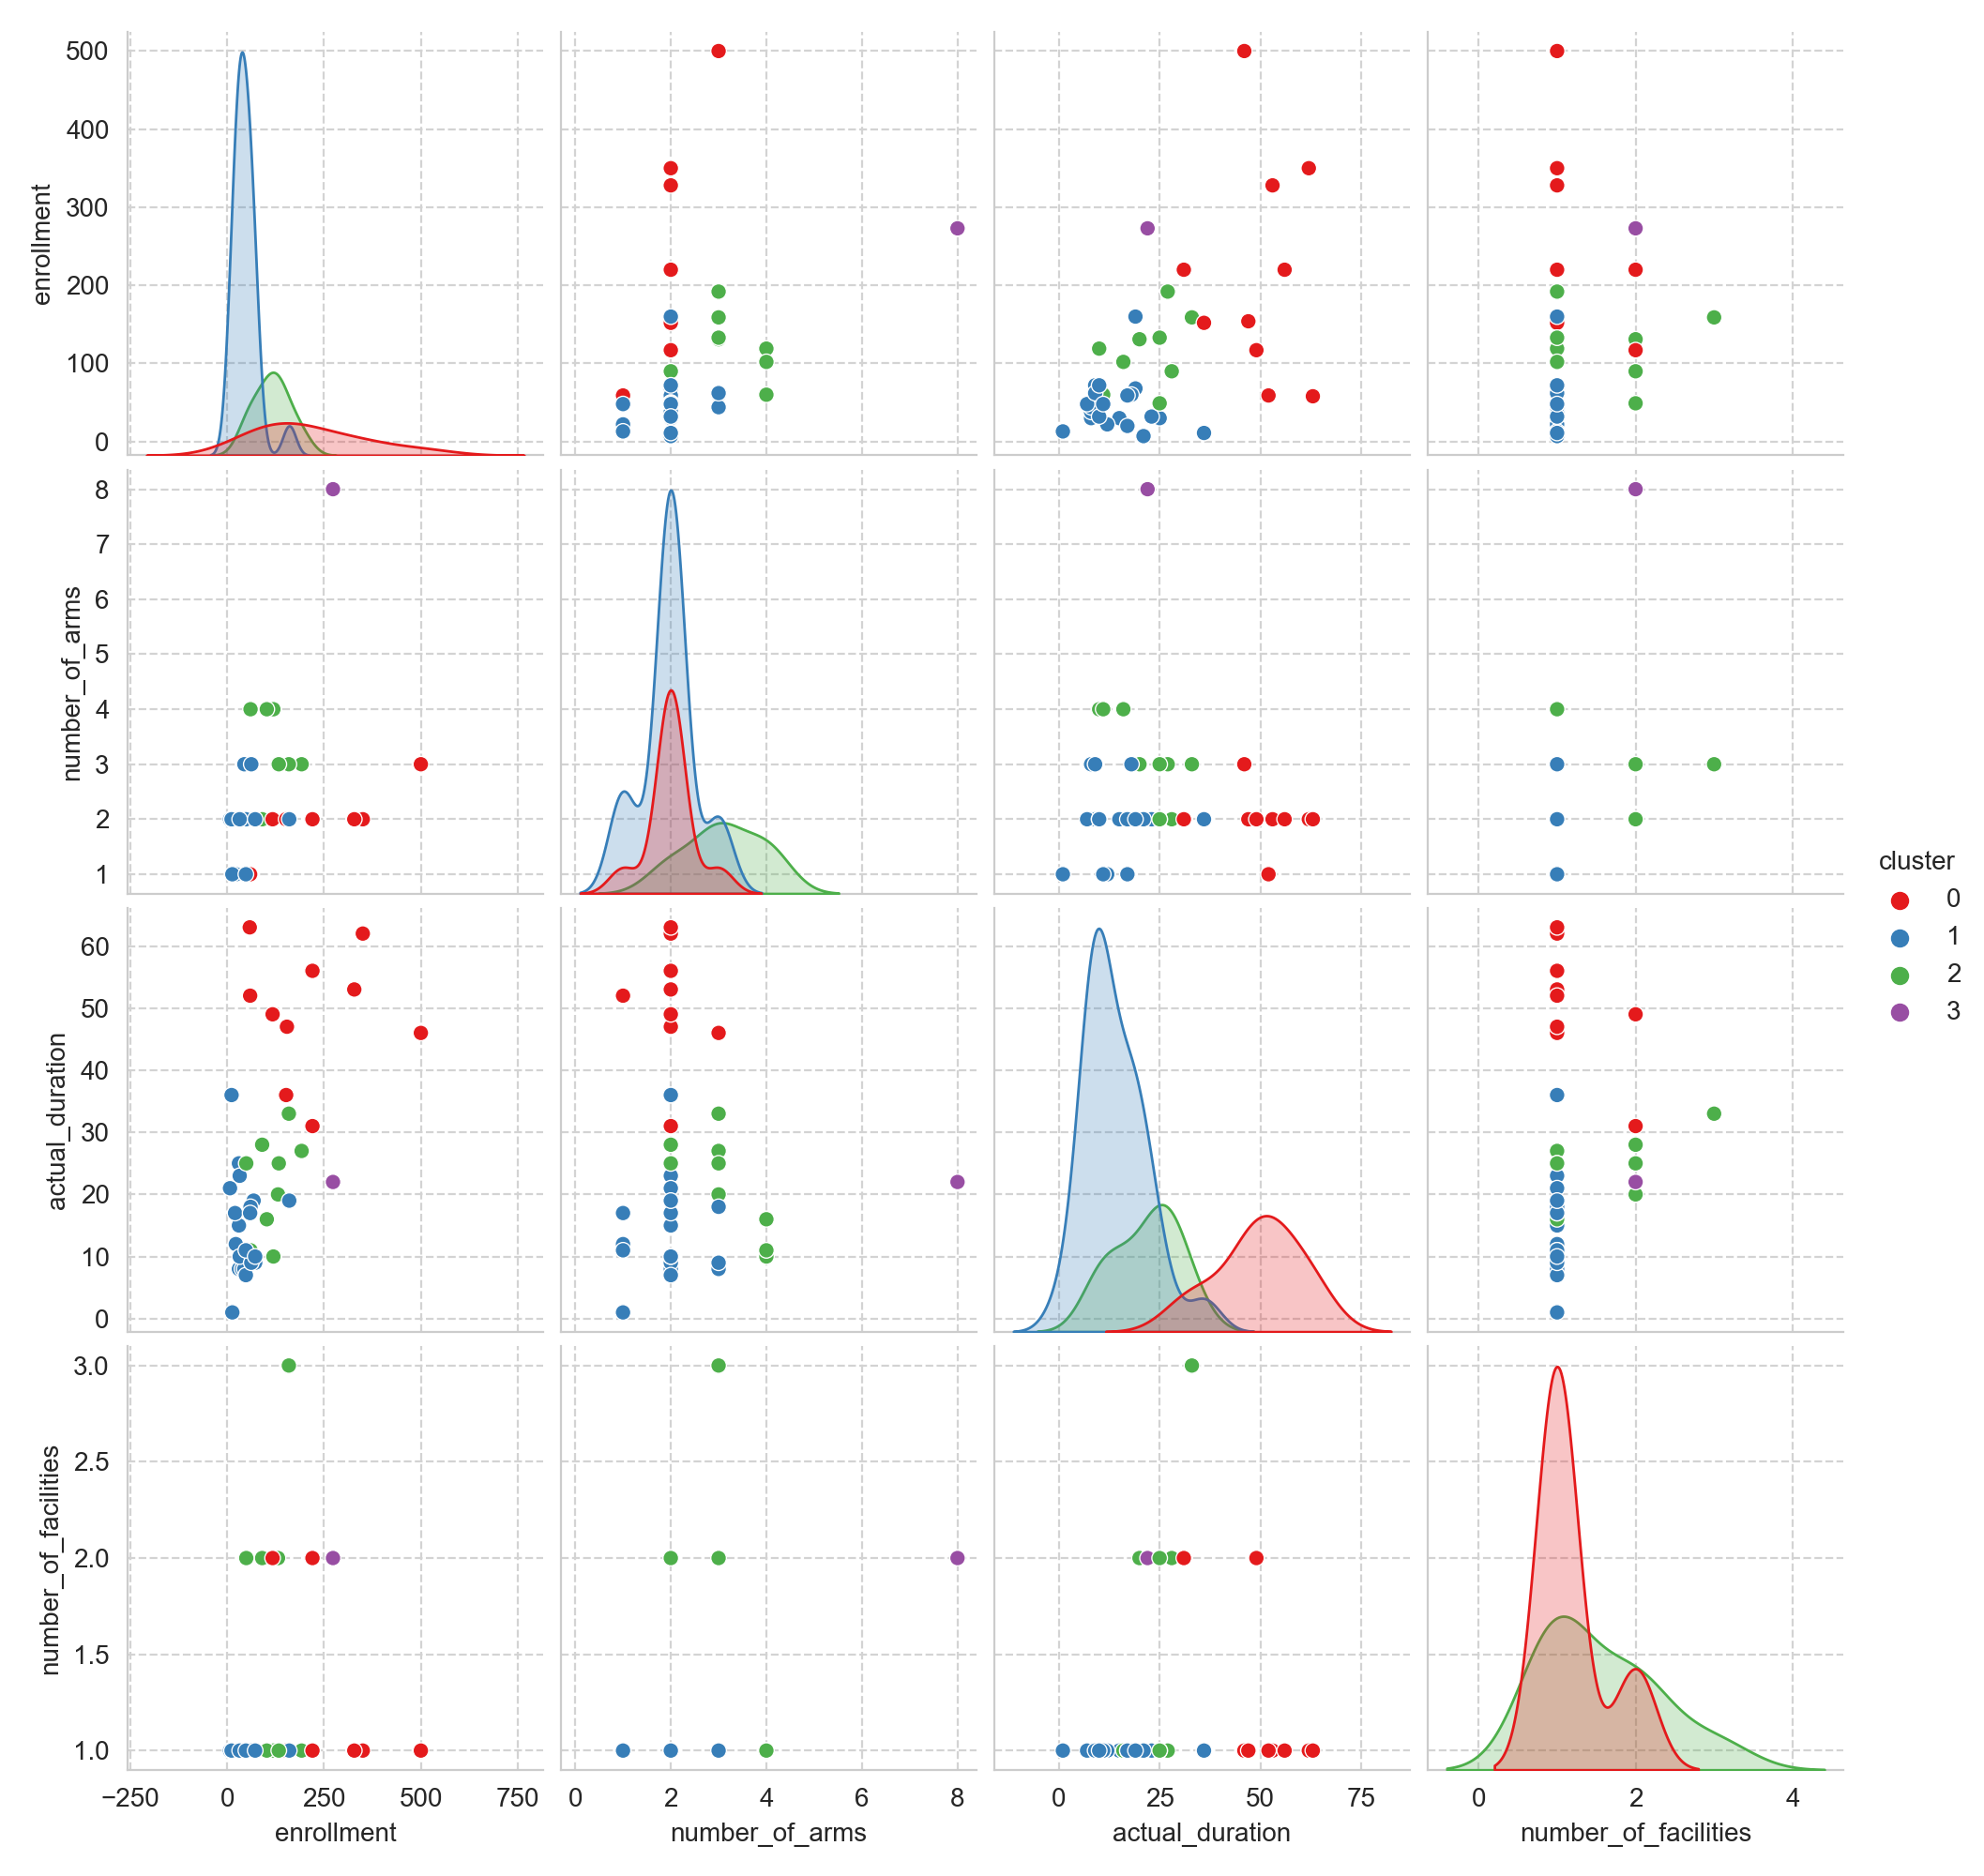

In [983]:
method_data['cluster'] = method_data['cluster'].astype('category')
cluster_colors = sns.color_palette('Set1', n_colors=n_clusters)

# pairwise comparison plot
sns.pairplot(method_data, hue="cluster", palette=cluster_colors)

plt.show()

## 7.4. Next, We will implement the outlier detection using k=1 clustering. This approach focuses on identifying outliers by their distance from the centroid in a single cluster scenario.

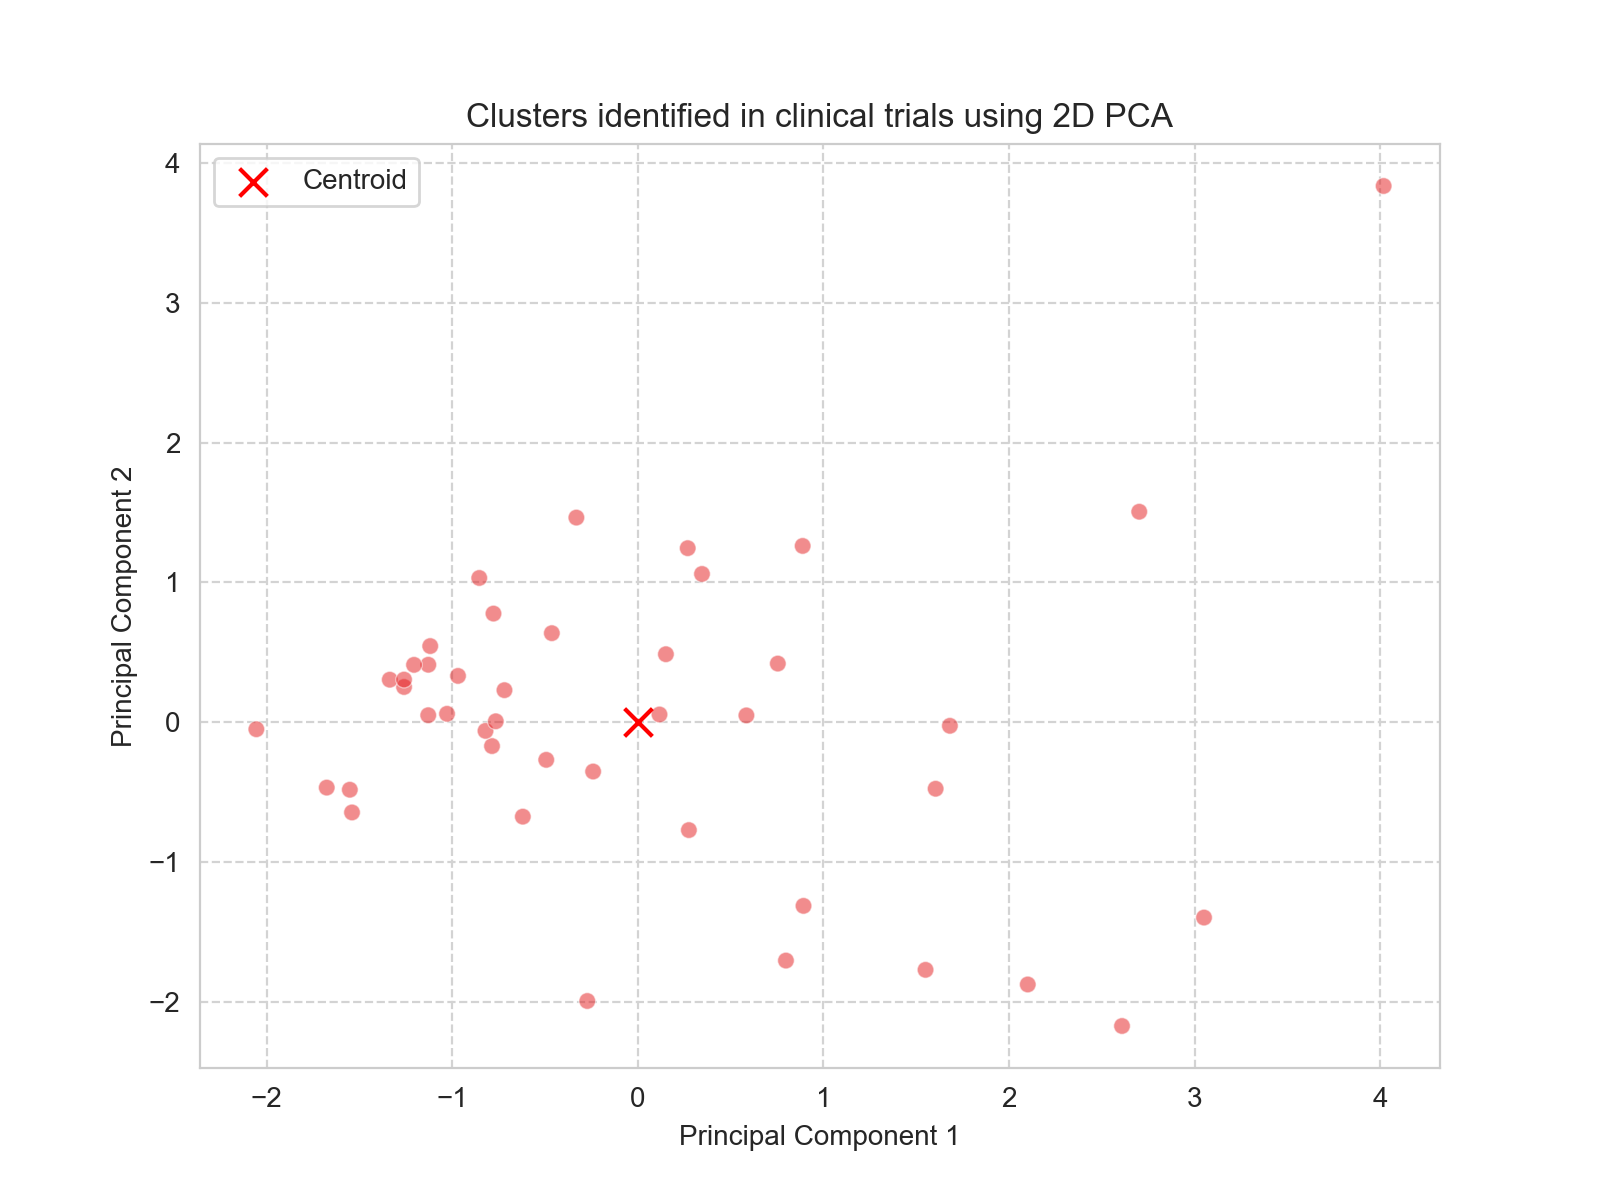

In [984]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['enrollment', 'number_of_arms', 'actual_duration', 'number_of_facilities']),
        ('cat', OneHotEncoder(), ['intervention_model', 'masking', 'phase'])
    ])

X_preprocessed = preprocessor.fit_transform(method_data)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_preprocessed)

kmeans = KMeans(n_clusters=1, random_state=1)
clusters = kmeans.fit_predict(pca_components)
method_data['cluster'] = clusters  # Safely assign cluster labels back to the DataFrame

# plot setup
plt.figure(figsize=(8, 6))
cluster_colors = sns.color_palette('Set1', n_colors=1)

# scatter plot of PCA components
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue='cluster', 
                data=method_data, palette=cluster_colors, alpha=0.5, legend=False)

# mark the centroid
for i, centroid in enumerate(kmeans.cluster_centers_):
    plt.scatter(centroid[0], centroid[1], marker="x", color="red", s=100, label='Centroid')

plt.title('Clusters identified in clinical trials using 2D PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

In [985]:
# Calculate distances from the cluster centroid
distances = kmeans.transform(pca_components)

# Sort the distances in descending order and select the top 5 indices
sorted_idx = np.argsort(distances.ravel())[::-1][:3]

# Retrieve the 'nct_id' values for the top 5 outliers
outlier_nct_ids = method_data.iloc[sorted_idx]['nct_id'].values

# Print the 'nct_id' values of the top 5 outliers
print(f"nct_id of the top 3 outliers: {outlier_nct_ids}")

nct_id of the top 3 outliers: ['NCT02868034' 'NCT00939107' 'NCT00118430']


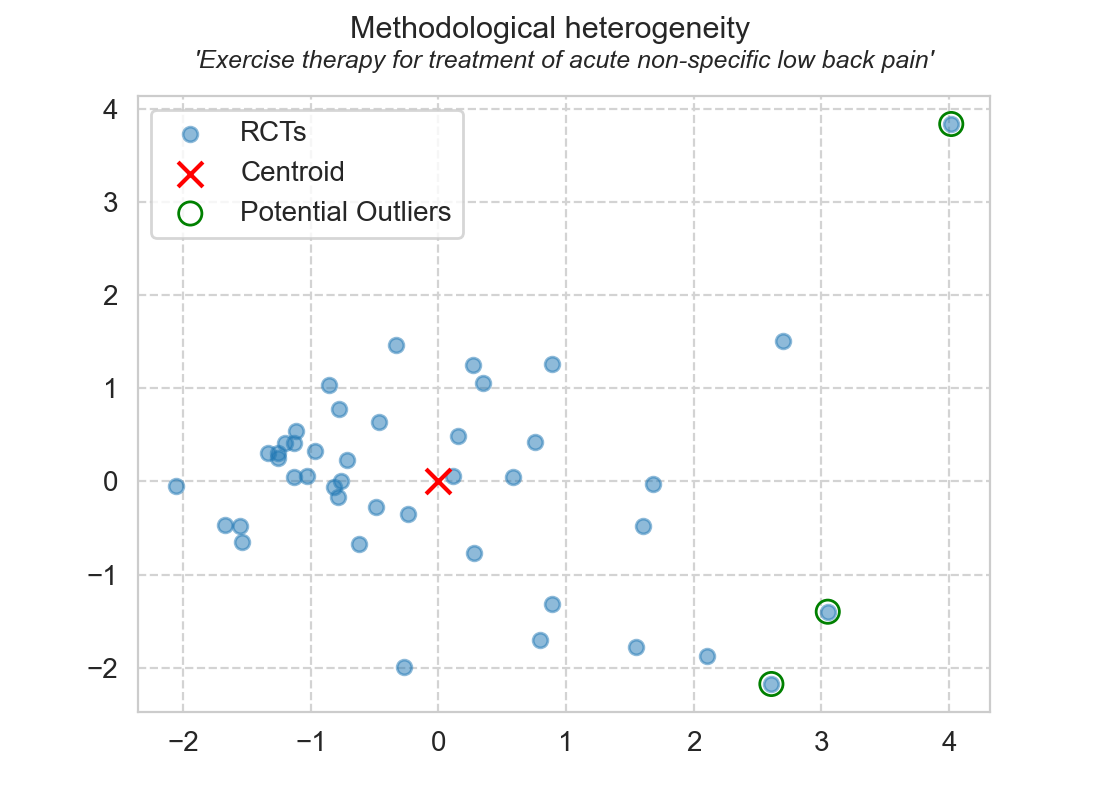

In [986]:
f, ax = plt.subplots(figsize=(5.5, 4))
f.suptitle("Methodological heterogeneity", fontsize=11)
ax.set_title("'Exercise therapy for treatment of acute non-specific low back pain'", fontstyle='italic', fontsize=9, pad=10)

# 'Exercise therapy for treatment of acute non-specific low back pain'
# 'PARP inhibitors for locally advanced or metastatic breast cancer'

# a scatter plot
ax.scatter(pca_components[:, 0], pca_components[:, 1], label='RCTs', alpha=0.5, s=28, marker='o')  # Reduced size for general points

# marking the centroid
ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], label='Centroid', color='r', s=80, marker='x')  # Changed marker to 'x'

# highlight the outliers (extreme value points)
ax.scatter(pca_components[sorted_idx][:, 0], pca_components[sorted_idx][:, 1], label='Potential Outliers', edgecolors='g', facecolors='none', s=70)

# get the 'nct_id'for the top x outliers
#outlier_nct_ids = method_data.iloc[sorted_idx]['nct_id'].values

# annotate each outlier point with its nct_id
#for i, txt in enumerate(outlier_nct_ids):
#    ax.annotate(txt, (pca_components[sorted_idx][i, 0], pca_components[sorted_idx][i, 1]), color='grey', fontsize=7.6, rotation=15)

    
# Adding legend
ax.legend(loc='best')
ax.grid(True)
plt.show()

### 7.5. Next,  We can formalize the outlier-detection by introducing a threshold measure

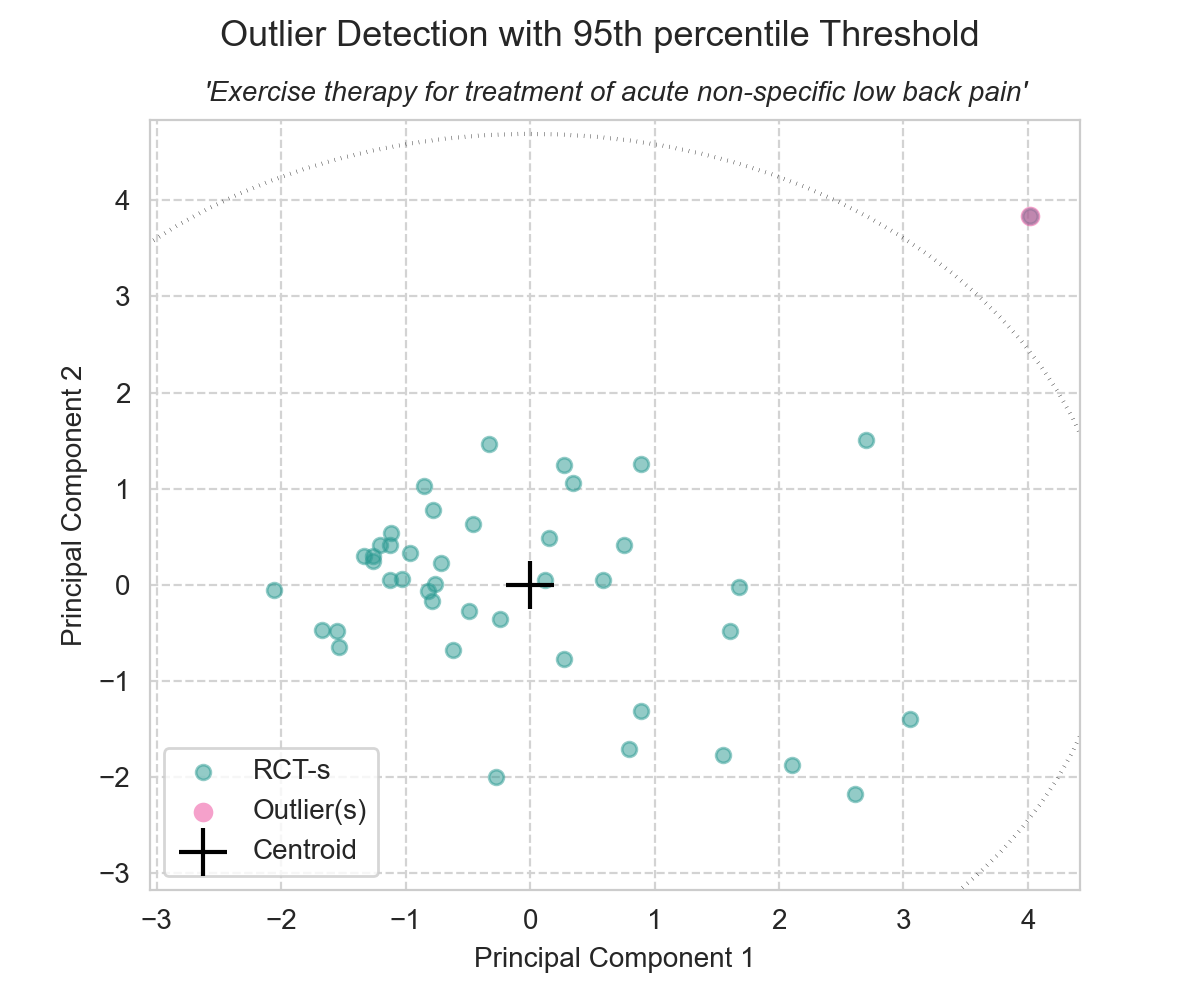

In [987]:
# calculate pairwise euclidean distances
dist_matrix = squareform(pdist(pca_components, 'euclidean'))

# determine threshold value - using the 95th percentile as an example
threshold = np.percentile(dist_matrix, 95)

# calculate distances from each point to the cluster centroid
centroid_distances = kmeans.transform(pca_components).ravel()

# identify outliers as those with distances greater than the threshold
outliers = np.where(centroid_distances > threshold)[0]

# plot setup
plt.figure(figsize=(6, 5))

# scatter plot for data points with squares
plt.scatter(pca_components[:, 0], pca_components[:, 1], color='#289991', s=28,  alpha=0.5, marker='o', label='RCT-s')
# scatter plot for outliers, keep as circles but you can change to squares by adding marker='s'
plt.scatter(pca_components[outliers, 0], pca_components[outliers, 1], color='#ed4599', s=50,  alpha=0.5, edgecolors='#ed4599', linewidth=0, label='Outlier(s)', marker='o')

# mark the centroid with plus marker
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='+', color='black', s=300, label='Centroid')

centroid = kmeans.cluster_centers_[0]  # Assuming single cluster for simplicity
theta = np.linspace(0, 2*np.pi, 100)
x = centroid[0] + threshold * np.cos(theta)
y = centroid[1] + threshold * np.sin(theta)
plt.plot(x, y, color='black', linestyle='--', dashes=[0.09, 1.5])  # Custom dash pattern

# Set the limits of the plot to the range of the PCA components
x_min, x_max = pca_components[:, 0].min() - 1, pca_components[:, 0].max() + 0.4
y_min, y_max = pca_components[:, 1].min() - 1, pca_components[:, 1].max() + 1
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.suptitle('Outlier Detection with 95th percentile Threshold', fontsize=13, weight='light') # Main title
plt.title("'Exercise therapy for treatment of acute non-specific low back pain'", fontstyle='italic', fontsize=10, pad=7, loc='center') # Subtitle
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()

# Finally, show the plot with the threshold circle added
plt.show()


# <span style="color:blue">8.1. Overall heterogeneity: Find the optimal number of clusters</span>

In [988]:
#data = data.dropna()
data.head()

,nct_id,female_pct,white_pct,avg_age,intervention_model,masking,enrollment,arms,phase,duration,number_of_facilities
0,NCT00118430,0.518000,0.582000,59.0,Parallel Assignment,None (Open Label),500,3,Phase 4,46,1.0
1,NCT00285649,0.463542,0.880208,40.0,Parallel Assignment,Single,192,3,Not Applicable,27,1.0
2,NCT01221233,0.470588,0.941176,71.6,Parallel Assignment,None (Open Label),38,2,Not Applicable,9,1.0
3,NCT01312233,0.389313,0.938931,72.7,Parallel Assignment,Single,131,3,Not Applicable,20,2.0
4,NCT01726803,0.522727,0.813636,37.5,Parallel Assignment,Double,220,2,Not Applicable,31,2.0


In [989]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   nct_id                20 non-null     object 
 1   female_pct            20 non-null     float64
 2   white_pct             20 non-null     float64
 3   avg_age               20 non-null     float64
 4   intervention_model    20 non-null     object 
 5   masking               20 non-null     object 
 6   enrollment            20 non-null     int64  
 7   arms                  20 non-null     int64  
 8   phase                 20 non-null     object 
 9   duration              20 non-null     int64  
 10  number_of_facilities  20 non-null     float64
dtypes: float64(4), int64(3), object(4)
memory usage: 1.8+ KB


<function matplotlib.pyplot.show(close=None, block=None)>

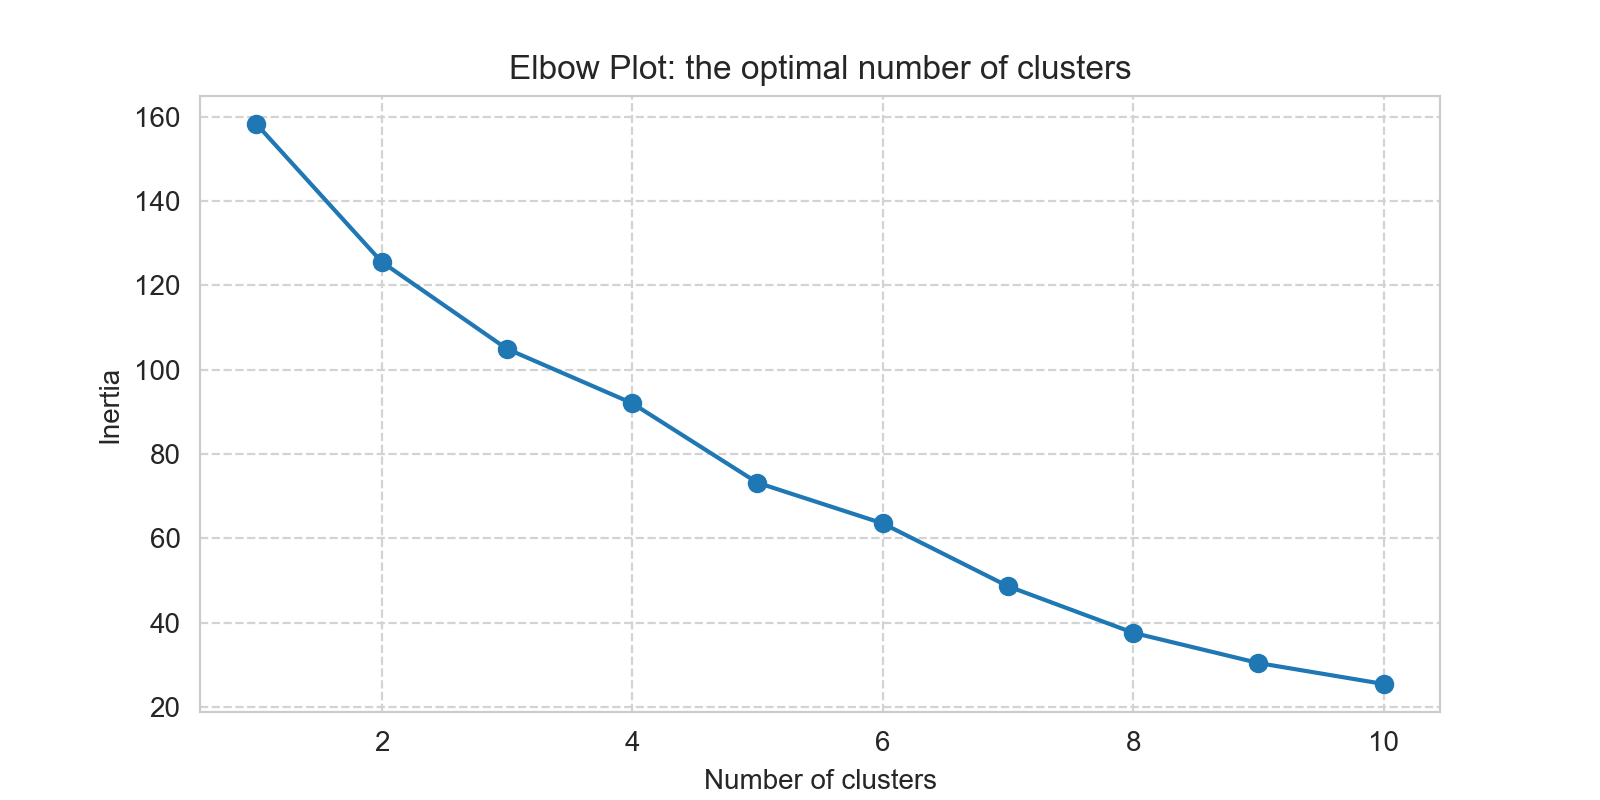

In [990]:
# define numerical columns
num_cols = ['female_pct', 'white_pct', 'avg_age', 'enrollment', 'arms', 'duration', 'number_of_facilities']
cat_cols = ['intervention_model', 'masking', 'phase']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(), cat_cols)
    ])

X = data
X_preprocessed = preprocessor.fit_transform(X)

inertia = []
K = range(1, 11)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=1)
    kmeanModel.fit(X_preprocessed)
    inertia.append(kmeanModel.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K, inertia, 'o-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Plot: the optimal number of clusters')
plt.show

## <span style="color:blue">8.2. Overal heterogeneity: K-Means Clustering (k=1)</span>

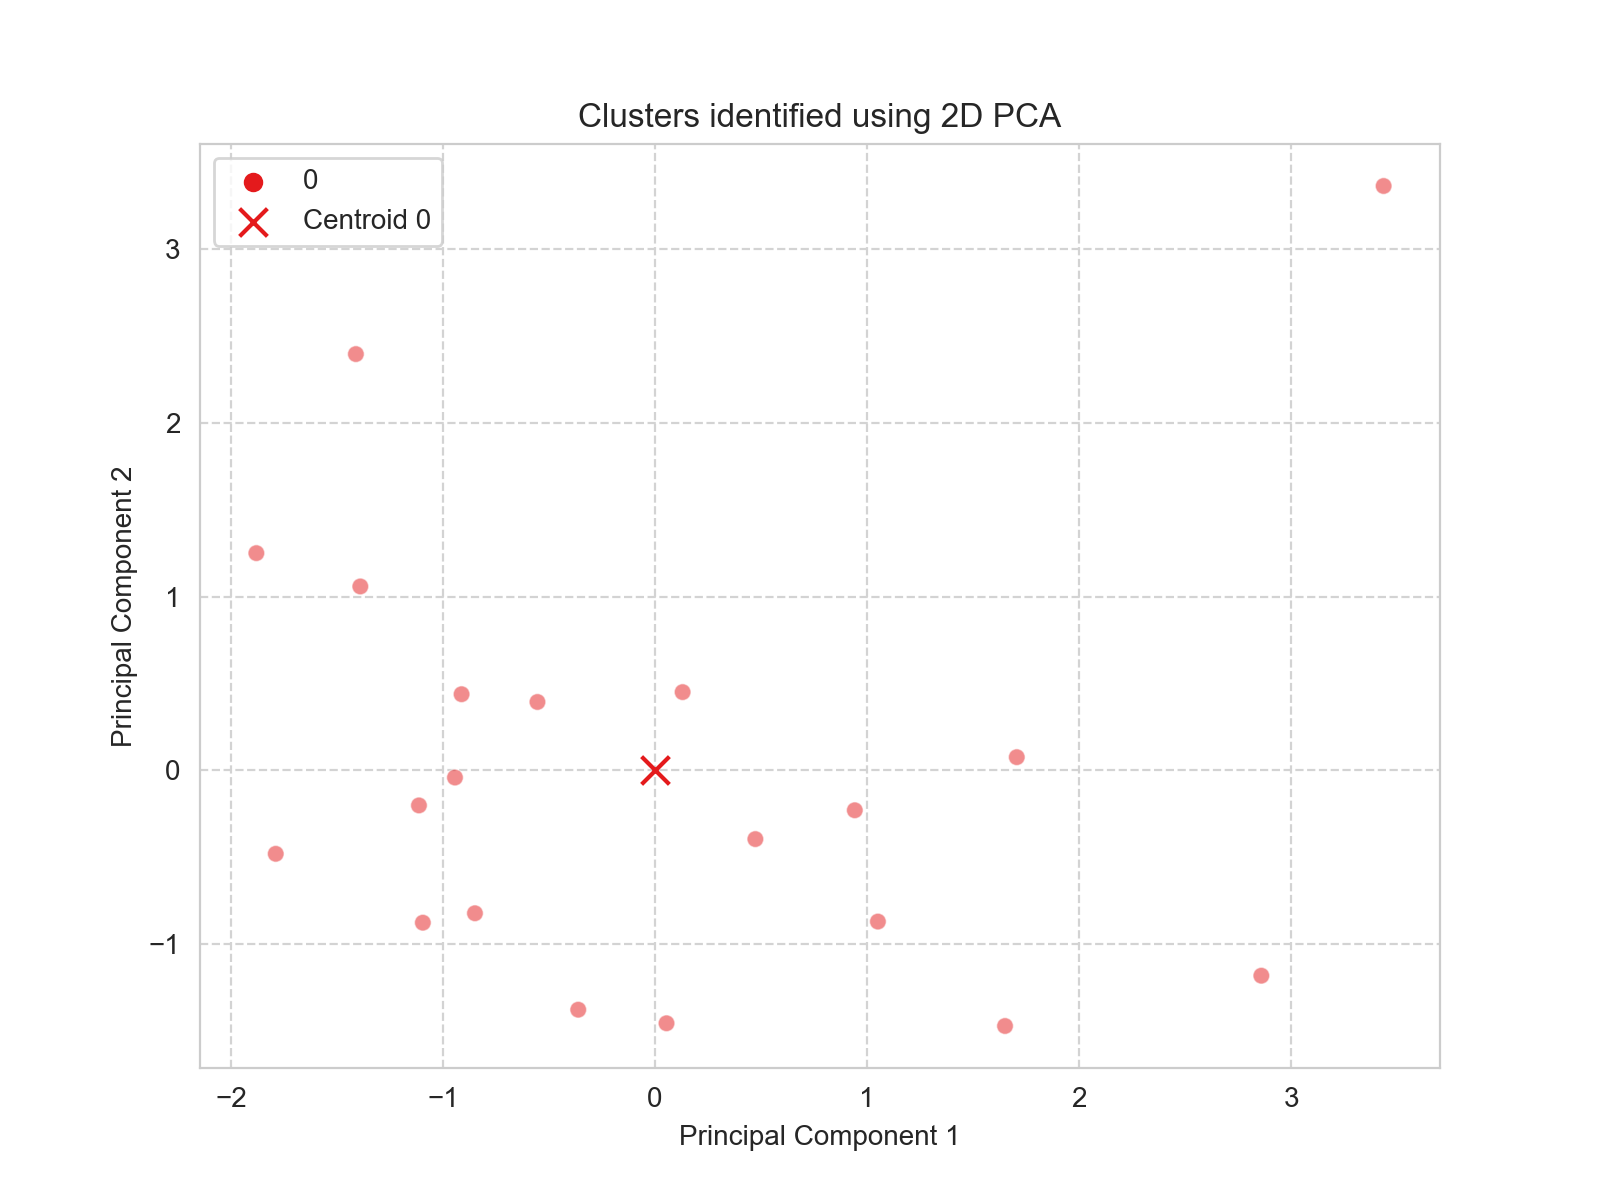

In [991]:
# Define numerical and categorical columns
num_cols = ['female_pct', 'white_pct', 'avg_age', 'enrollment', 'arms', 'duration', 'number_of_facilities']
cat_cols = ['intervention_model', 'masking', 'phase']

# Create the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(), cat_cols)
    ])

# Apply transformations
X_preprocessed = preprocessor.fit_transform(data)

# Adjust PCA to have 2 components for 2D visualization
pca = PCA(n_components=2)  # Adjust to 2 for 2D plotting
pca_components = pca.fit_transform(X_preprocessed)

n_clusters = 1
kmeans = KMeans(n_clusters=n_clusters, random_state=1)
clusters = kmeans.fit_predict(pca_components)

data['cluster'] = clusters

cluster_colors = sns.color_palette('Set1', n_colors=n_clusters)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=data['cluster'], palette=cluster_colors, alpha=0.5, legend='full')

# plotting the centroid
for i, centroid in enumerate(kmeans.cluster_centers_):
    plt.scatter(centroid[0], centroid[1], marker="x", color=cluster_colors[i], s=100, label=f'Centroid {i}')

plt.title('Clusters identified using 2D PCA')
plt.xlabel('Principal Component 1')  # Adding axis label for PCA Component 1
plt.ylabel('Principal Component 2')  # Adding axis label for PCA Component 2
plt.legend()
plt.show()

In [1002]:
# Add the minimum distance as a new column in the DataFrame
data['distance_score'] = min_distances

# Now sort the DataFrame by 'distance_score' in descending order to get outliers on top
data_sorted = data.sort_values('distance_score', ascending=False)

# If you want the top x outliers, you can adjust this number
top_x = 4
outlier_nct_ids = data_sorted.head(top_x)['nct_id'].values

# Save the DataFrame with added 'distance_score'
#data.to_csv('data_kmeans_breast.csv', index=False)

# Print the 'nct_id' values of the top x outliers
print(f"nct_id of the top {top_x} outliers: {outlier_nct_ids}")

nct_id of the top 4 outliers: ['NCT03360344' 'NCT03415464' 'NCT00118430' 'NCT02524158']


## 8.3. We can also explore the parallel coordinates plot for a visual glimpse into how the outliers differ

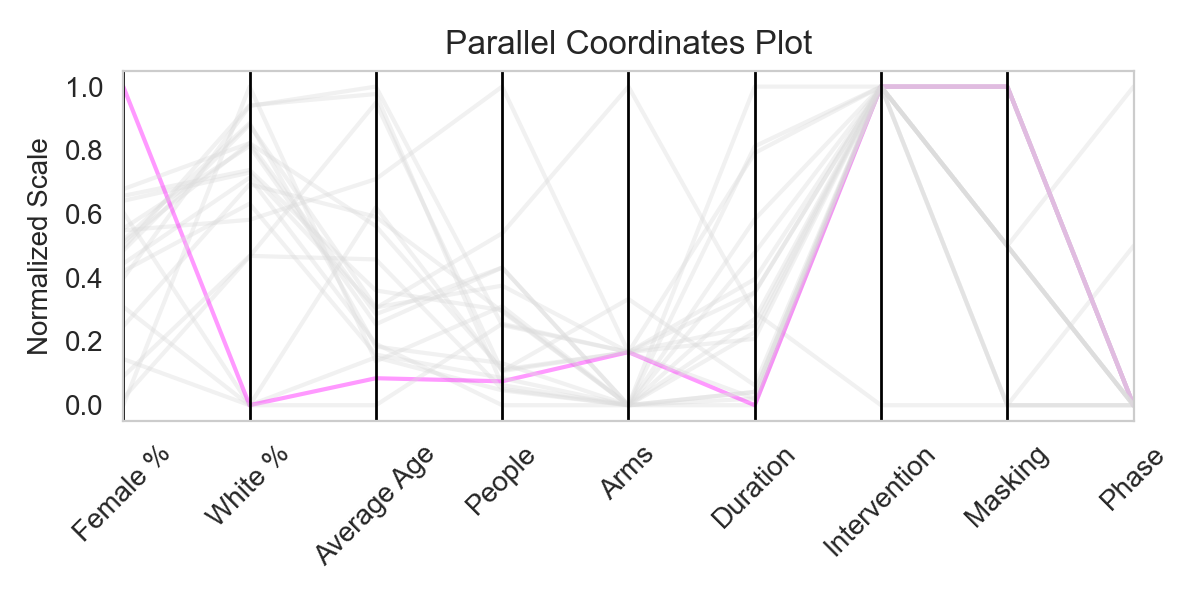

In [1001]:
scaler = MinMaxScaler()
numeric_vars = ['female_pct', 'white_pct', 'avg_age', 'enrollment', 'arms', 'duration']
data[numeric_vars] = scaler.fit_transform(data[numeric_vars])

categorical_vars = ['intervention_model', 'masking', 'phase']
for var in categorical_vars:
    data[var + '_code'] = data[var].astype('category').cat.codes
categorical_codes = [var + '_code' for var in categorical_vars]
data[categorical_codes] = scaler.fit_transform(data[categorical_codes])

# determine the top 3 trials based on the 'distance_score'
top_3_indices = data['distance_score'].nlargest(3).index
data['highlight'] = 'Other Trials'
data.loc[top_3_indices, 'highlight'] = ['Top 1', 'Top 2', 'Top 3']

plot_df = data[numeric_vars + categorical_codes + ['highlight']]

colors = {'Other Trials': 'gainsboro', 'Top 1': 'magenta', 'Top 2': 'gainsboro', 'Top 3': 'gainsboro'} #update colors!

fig, ax = plt.subplots(figsize=(6, 3))
parallel_coordinates(plot_df, class_column='highlight', 
                     color=[colors[x] for x in plot_df['highlight'].unique()], 
                     alpha=0.4, ax=ax)  # Adjusted alpha for visibility
plt.title('Parallel Coordinates Plot')
#plt.xlabel('Variables')
plt.ylabel('Normalized Scale')

custom_labels = [
    'Female %', 
    'White %', 
    'Average Age', 
    'People', 
    'Arms', 
    'Duration',
    'Intervention', 
    'Masking',        
    'Phase'                
]

plt.xticks(ticks=np.arange(len(custom_labels)), labels=custom_labels, rotation=45)  # Adjust rotation if necessary

ax.legend().remove()

plt.tight_layout()
plt.show()


## Extra 1: Isolation forest algorithm

In [934]:
# select only the quantitative columns
data_for_outlier_detection = data[['enrollment', 'arms', 'duration', 'number_of_facilities']]

# adjust the parameters like n_estimators, max_samples, and contamination as needed

iso_forest = IsolationForest(n_estimators=100, max_samples='auto', contamination=float(0.01), random_state=42)

# model fitting
iso_forest.fit(data_for_outlier_detection)

IsolationForest(contamination=0.01, random_state=42)

In [935]:
# Predict anomalies (-1 for outliers and 1 for inliers)
outliers = iso_forest.predict(data_for_outlier_detection)

data['outlier'] = outliers

outlier_data = data[data['outlier'] == -1]

print(outlier_data)

         nct_id  female_pct  white_pct  avg_age    intervention_model masking  \
11  NCT02868034     0.59751    0.73029     39.9  Factorial Assignment  Double   

    enrollment  arms    phase  duration  number_of_facilities  cluster  \
11         273     8  Phase 2        22                   2.0        0   

    outlier  
11       -1  


## Extra 2: intervention level variables

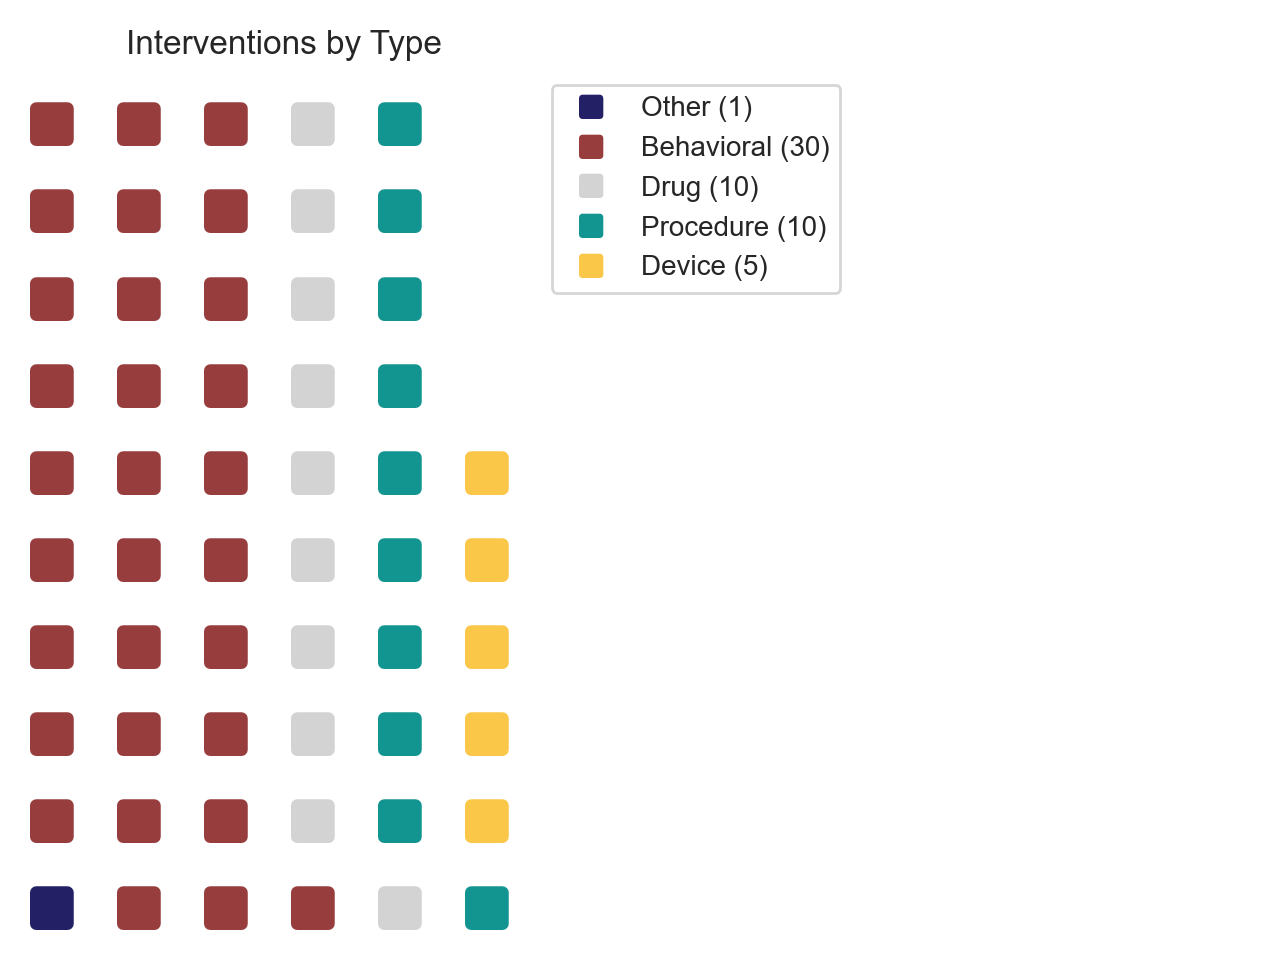

In [936]:
intervention_types = {
    'Other': 1,
    'Behavioral': 30,
    'Drug': 10,
    'Procedure': 10,
    'Device': 5
}

fig = plt.figure(
    FigureClass=Waffle, 
    rows=10,
    values=intervention_types, 
    colors=["#232066", "#983D3D", "#D3D3D3", "#129490", "#FAC748"],
    title={'label': 'Interventions by Type', 'loc': 'center'}, 
    labels=[f"{k} ({v})" for k, v in intervention_types.items()],
    legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1)},
    icons='square',
    icon_size=18,
    icon_legend=True
)

plt.show()

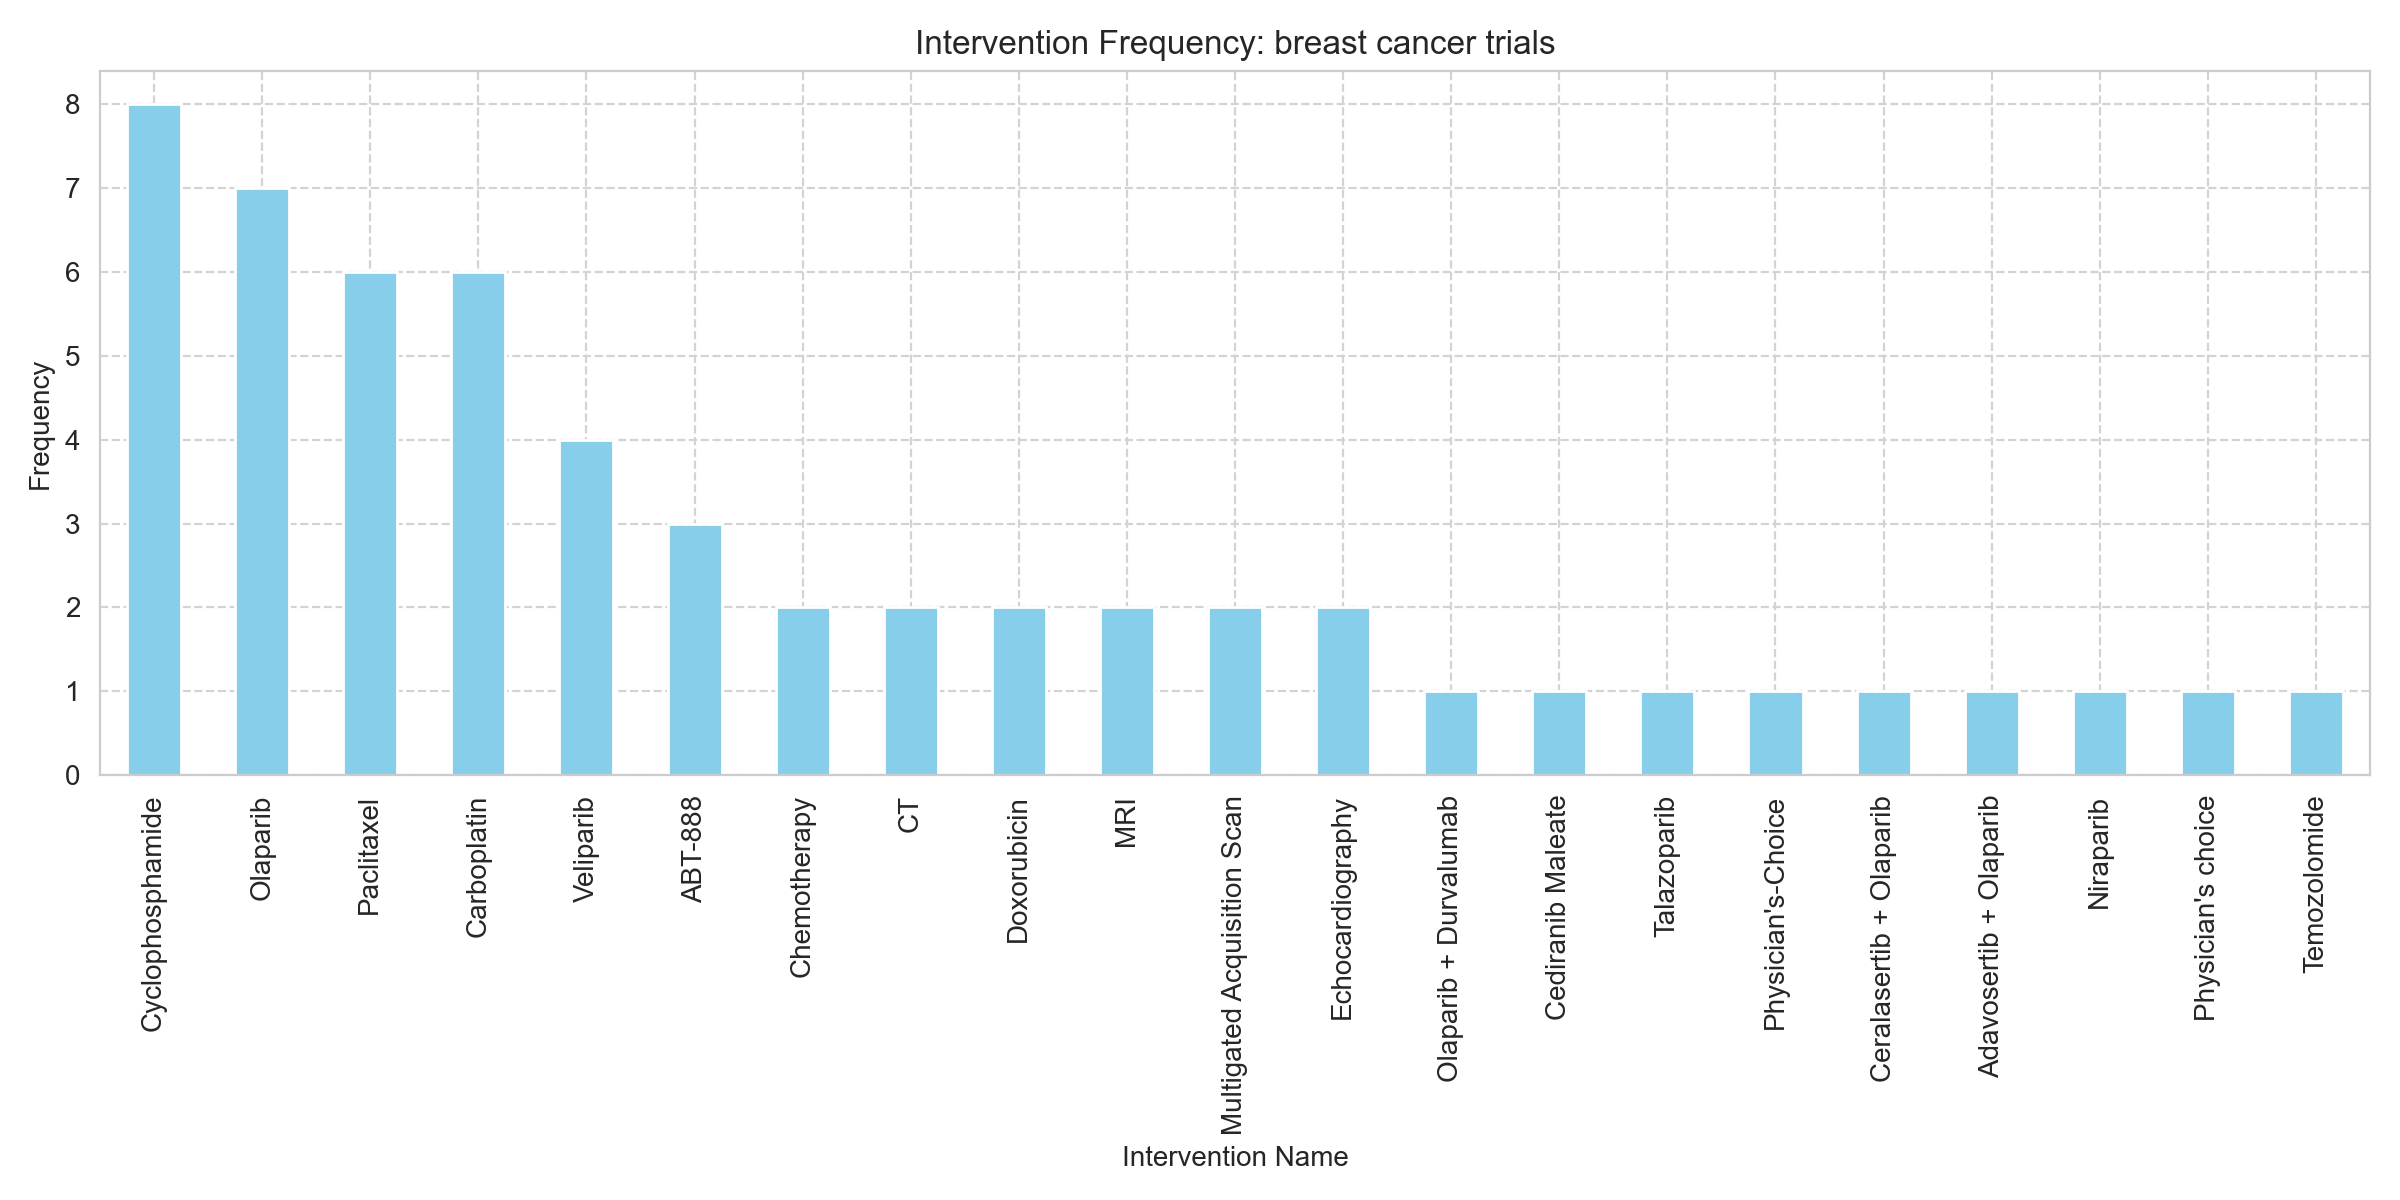

In [937]:
data = pd.read_csv("int.csv")

intervention_counts = data['name'].value_counts()

plt.figure(figsize=(12, 6))
intervention_counts.plot(kind='bar', color='skyblue')
plt.title('Intervention Frequency: breast cancer trials')
plt.xlabel('Intervention Name')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

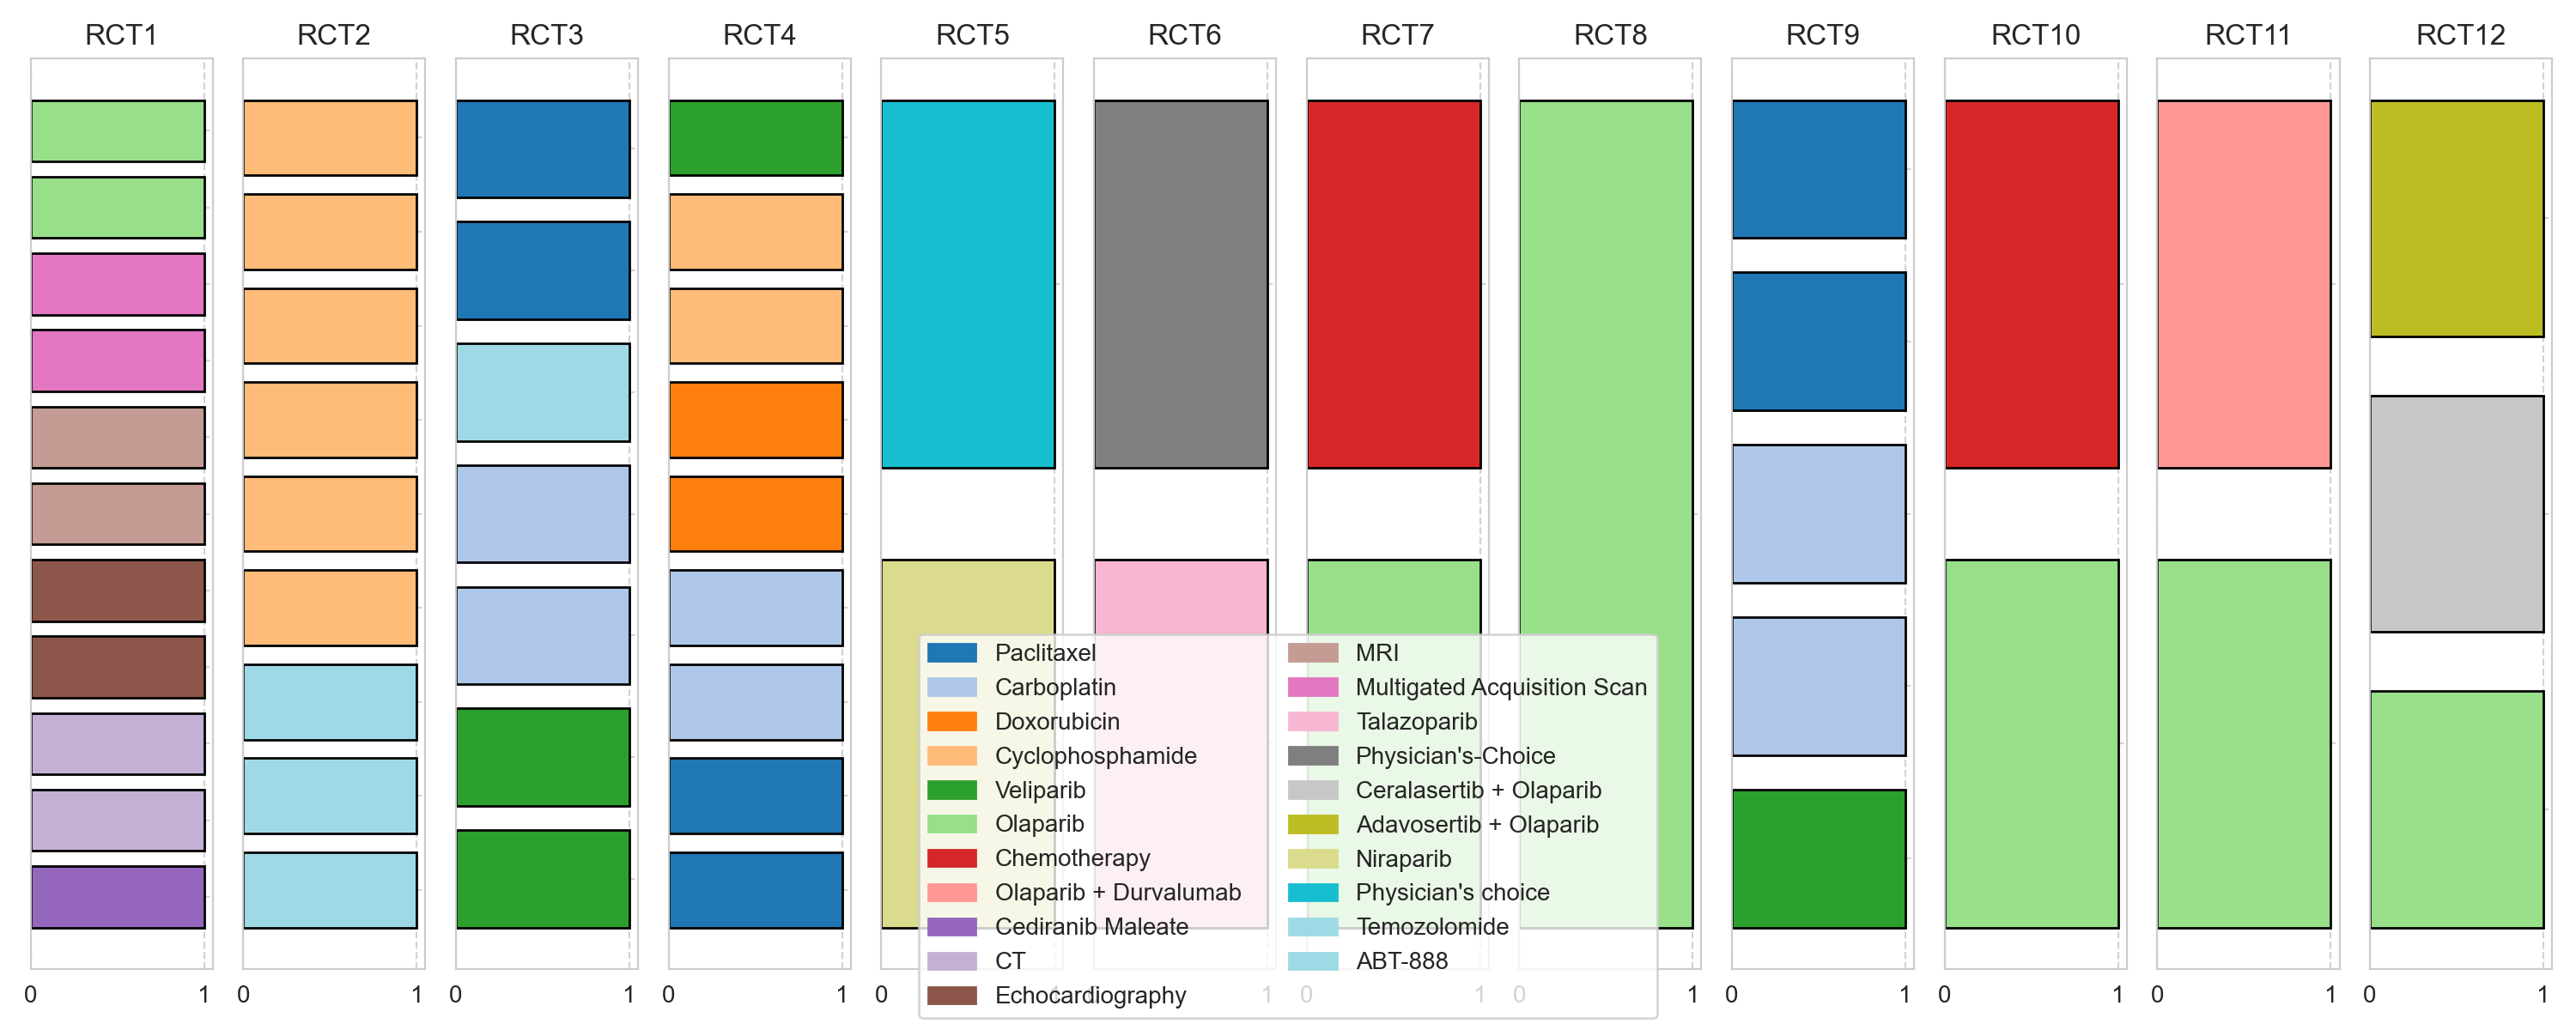

In [938]:
data = pd.read_csv("int.csv")

grouped_data = data.groupby("nct_id")["name"].apply(list).reset_index()

num_nct_ids = len(grouped_data)
fig, axes = plt.subplots(1, num_nct_ids, figsize=(15, 6))

new_labels = [f"RCT{i+1}" for i in range(num_nct_ids)]

unique_interventions = data["name"].unique()
color_map = {intervention: plt.cm.tab20(i) for i, intervention in enumerate(unique_interventions)}

legend_handles = []
legend_labels = []
for intervention, color in color_map.items():
    legend_handles.append(plt.Rectangle((0, 0), 1, 1, color=color))
    legend_labels.append(intervention)

for i, (nct_id, treatment_names) in enumerate(zip(grouped_data["nct_id"], grouped_data["name"])):
    ax = axes[i]
    colors = [color_map[treatment] for treatment in treatment_names]
    ax.barh(np.arange(len(treatment_names)), [1] * len(treatment_names), color=colors, edgecolor='black')
    ax.set_yticks(np.arange(len(treatment_names)))
    ax.set_yticklabels([""] * len(treatment_names))  # Empty labels initially
    ax.set_title(new_labels[i])  # Use the new labels
    
    mplcursors.cursor(ax, hover=True).connect("add", lambda sel: sel.annotation.set_text(treatment_names[sel.target.index]))

num_legend_columns = 2  # Change this as needed
fig.legend(legend_handles, legend_labels, loc="lower center", ncol=num_legend_columns)
    
plt.tight_layout(pad=1.0)  # Adjust the spacing between subplots
plt.show()